In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", interp_length=None, transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.interp_length = interp_length
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        # Process ADC channels.
        if self.interp_length is not None:
            audio_arr = self._interpolate_channel(audio_arr, self.interp_length)
            adc1_arr = self._interpolate_channel(adc1_arr, self.interp_length)
            adc2_arr = self._interpolate_channel(adc2_arr, self.interp_length)
        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def _interpolate_channel(self, arr, target_length):
        """
        Remove np.inf values from the array and linearly interpolate
        to the target_length.
        """
        # Remove padded inf values.
        valid = arr[~np.isinf(arr)]
        if len(valid) == 0:
            # If there is no valid data, return an array of zeros.
            return np.zeros(target_length, dtype=arr.dtype)
        # Generate new indices for interpolation.
        old_indices = np.arange(len(valid))
        new_indices = np.linspace(0, len(valid) - 1, target_length)
        return np.interp(new_indices, old_indices, valid)[:target_length]

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist

        valid_data = data[~np.isinf(data)]
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, valid_data)
        padded_filtered_data = np.full(data.shape, np.inf)  # Create an array with the same shape as input data, filled with np.inf
        # Replace the valid data positions with the filtered data
        padded_filtered_data[~np.isinf(data)] = filtered_data
        # Return the filtered data, maintaining the original shape of the input data
        return padded_filtered_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, audio, adc1, adc2 = sample
        audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[1]) / self.std[1]
        adc2 = (adc2 - self.mean[1]) / self.std[1]
        return id, audio, adc1, adc2

input_length = 512
# Path to the descriptor JSON file.
descriptor_path = 'samdescriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
dataset = MemmapDataset(descriptor_path, padding_handling=np.inf, filter=True)
# dataset = MemmapDataset(descriptor_path, padding_handling="remove", filter=True)
transform = normalizer(mean=[dataset.get("audio_mean"), dataset.get("adc_mean")], std=[dataset.get("audio_std"), dataset.get("adc_std")])
dataset.transform = transform
output_length = dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = dataset[1]
print(f"\nWith ADC interpolation to length {input_length}:")
print("ADC1 shape:", sample[2].shape)
print("ADC2 shape:", sample[3].shape)

# Demonstrate accessing a descriptor field.
print("Audio Sampling Rate:", dataset.get("audio_sampling_rate"))
print("ADC Highcut:", dataset.get("adc_highcut"))


Number of classes: 38

With ADC interpolation to length 512:
ADC1 shape: torch.Size([5199])
ADC2 shape: torch.Size([5199])
Audio Sampling Rate: 48000
ADC Highcut: 3700


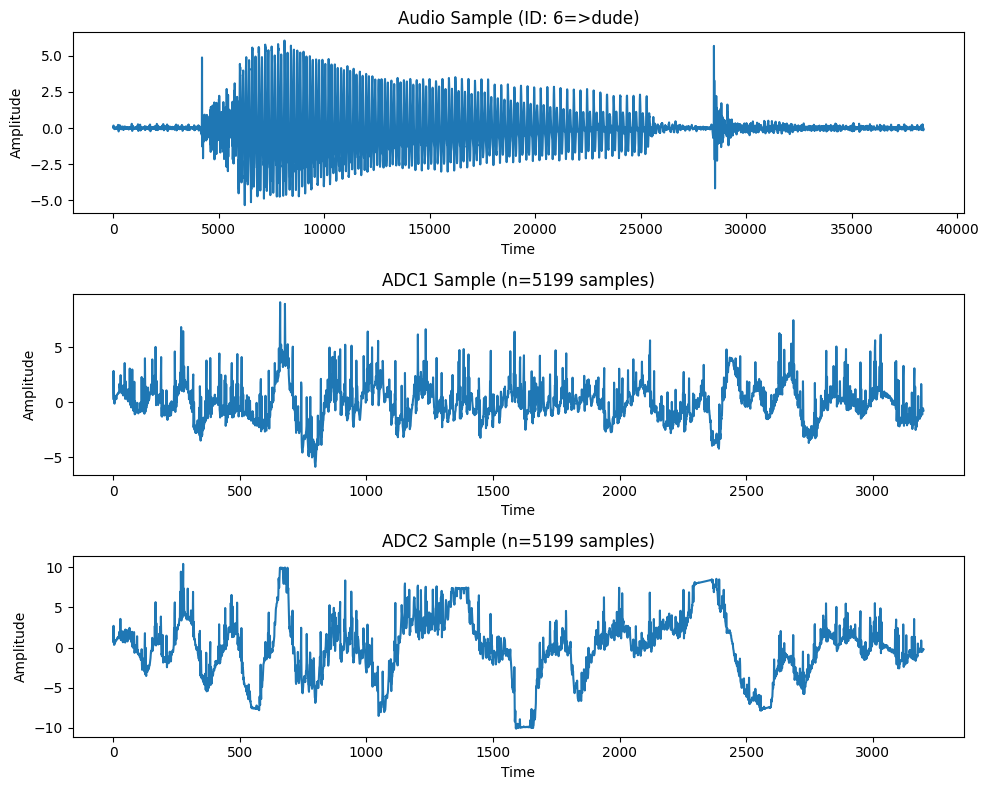

In [2]:
import matplotlib.pyplot as plt


rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

sample_id, audio, adc1, adc2 = sample  # unpack the tuple

# Convert tensors to numpy arrays for plotting
audio_np = audio.numpy()
adc1_np = adc1.numpy()
adc2_np = adc2.numpy()

# Create a figure with three subplots for audio, ADC1, and ADC2.
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(audio_np)
axs[0].set_title(f"Audio Sample (ID: {sample_id}=>{dataset.id_to_dataset(sample_id)})")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(adc1_np)
axs[1].set_title(f"ADC1 Sample (n={len(adc1_np)} samples)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

axs[2].plot(adc2_np)
axs[2].set_title(f"ADC2 Sample (n={len(adc2_np)} samples)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [3]:
from torch import nn


class V1dTransformer(nn.Module):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 input_kern = 16,  # Kernel size for the initial Conv1d layer
                 nhead=8, 
                 num_encoder_layers=6, 
                 dim_feedforward=512, 
                 dropout=0.1):
        super(V1dTransformer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_kern = input_kern  # Kernel size for the initial Conv1d layer
        self.stride = input_kern // 2  # Stride for the Conv1d layer, typically half of kernel size
        
        self.conv = nn.Conv1d(input_dim, dim_feedforward, kernel_size=self.input_kern, stride=self.stride)
        self.posencoding = nn.Embedding(10000, dim_feedforward)  # Positional encoding for up to 1000 positions
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim_feedforward,
                nhead=nhead,
                dim_feedforward=dim_feedforward*2,
                dropout=dropout,
                batch_first=True  # Set to True to match the input shape (batch_size, seq_length, d_model
            ),
            num_layers=num_encoder_layers
        )
        self.adapool = nn.AdaptiveAvgPool1d(1)  # Adaptive pooling to reduce the output to a fixed size
        self.fc_out = nn.Linear(dim_feedforward, output_dim)

    def compute_src_key_padding_mask(self, x: torch.Tensor) -> torch.Tensor:
        """
        Given input `x` of shape [B, C, L_in], which may be padded with inf at the end,
        return a boolean mask of shape [B, L_out], where L_out is the length after
        applying this model's initial conv.  A value of True means "ignore this token."
        """
        # x shape: [batch_size, channels, length_in]
        B, C, L_in = x.shape
        
        # 1) Identify which positions in each sequence are genuinely padded vs. real.
        #    We'll say a time-step is "padded" if ALL channels at that time-step are inf.
        #    So is_padded[i, t] = True if x[i, :, t] are all inf
        is_padded = torch.isinf(x).all(dim=1)  # [B, L_in], True = padded in all channels
        # is_real is then the logical NOT of padded
        is_real = ~is_padded                    # [B, L_in]
        
        # 2) real_length[i] = how many "real" positions for sample i
        #    (i.e., up to the first big block of inf)
        real_lengths = is_real.sum(dim=1)  # [B], integer count of real steps for each sample
        
        # 3) Determine how many "tokens" come out after the conv
        #    The formula for 1D conv with stride, padding, kernel_size is:
        #       L_out = floor( (L_in + 2*pad - kernel_size) / stride ) + 1
        L_out = (L_in - self.input_kern) // self.stride + 1
        # We'll build a mask [B, L_out]: True where the output token is invalid (padded).
        
        # 4) For a standard “center-based” approach, the center of output token i is i * stride.
        positions = torch.arange(L_out, device=x.device)   # [L_out],  i = 0..L_out-1
        center_ixs = positions * self.stride               # shape [L_out]
        
        # Expand to compare with each sample
        # shape => [B, L_out]
        center_ixs_batched = center_ixs.unsqueeze(0).expand(B, -1)
        
        # Expand real_lengths to [B, L_out]
        real_lengths_batched = real_lengths.unsqueeze(1).expand(-1, L_out)
        
        # 5) Mark as True where center_ix >= real_length => this token is "padded"
        src_key_padding_mask = center_ixs_batched >= real_lengths_batched  # [B, L_out], bool
        
        return src_key_padding_mask

    def forward(self, x, src_key_padding_mask=None):
        # If user didn't provide a mask, compute it from x
        if src_key_padding_mask is None:
            src_key_padding_mask = self.compute_src_key_padding_mask(x)
        x[torch.isinf(x)] = 0.0  # Replace np.inf with 0.0 for processing, this is a workaround for the Conv1d layer
        features = self.conv(x)  # Apply convolution to the input
        # features will now be of shape (batch_size, dim_feedforward, sequence_length)
        encoding_length = features.size(2)
        # Generate positional encodings
        pos_encoding = torch.arange(0, encoding_length, device=x.device).unsqueeze(0).expand(x.size(0), -1)
        pos_encoding = self.posencoding(pos_encoding)
        features = features.permute(0, 2, 1)  # Permute to (batch_size, sequence_length, dim_feedforward)
        # print(f"Positional encoding shape: {pos_encoding.shape}, features shape: {features.shape}")
        # Add positional encoding to the features
        features = features + pos_encoding
        # Permute the dimensions to match the expected input for TransformerEncoder
        # Transformer expects input in the shape (batch_size, seq_length, d_model)
        # features = features.permute(0, 2, 1)
        # Pass through the TransformerEncoder
        transformer_output = self.transformer_encoder(features, src_key_padding_mask=src_key_padding_mask)
        # Permute back to (batch_size, d_model, seq_length) for the final linear layer
        # transformer_output = transformer_output.permute(0, 2, 1)
        # print(f"Transformer output shape: {transformer_output.shape}")
        # Apply the final fully connected layer to get the output
        # Use adaptive pooling to reduce the sequence length to 1
        # pooled_output = self.adapool(transformer_output)
        # # pooled_output will now be of shape (batch_size, d_model, 1)
        # # Remove the last dimension to match the output dimension
        # pooled_output = pooled_output.squeeze(2)
        # # Pass through the final fully connected layer to get the output
        # output = self.fc_out(pooled_output)
        # Instead of adaptive pooling, directly pass last output from transformer to the fully connected layer
        # output = self.fc_out(transformer_output[:,:,-1])  # Pass through the final fully connected layer
        output = self.fc_out(transformer_output)  # Pass through the final fully connected layer
        # Output will now be of shape (batch_size, output_dim)
        return output.transpose(1, 2)  # Transpose to match the expected output shape (batch_size, output_dim)
        # return output  # Return the final output

dummy_input = torch.randn(4, 2, 40000)  # Example input with batch size 4, 512 channels, and sequence length 300
# set the last 1000 values to be inf
# This is just to simulate the input for testing purposes
dummy_input[:, :, :-1000] = float('inf')  # Simulate np.inf padding for testing
# Create an instance of the V1dTransformer
model = V1dTransformer(
    input_dim=2,  # Input dimension (number of channels)
    output_dim=output_length,  # Output dimension (number of classes)
    input_kern=16,  # Kernel size for the initial Conv1d layer
    nhead=4, 
    num_encoder_layers=2, 
    dim_feedforward=128, 
    dropout=0.1
)
# Forward pass through the model
# Note: Ensure the input tensor is in the shape (batch_size, input_dim, sequence_length)
# Forward pass through the model
key = model.compute_src_key_padding_mask(dummy_input)
# print(40000/32)
print(f"Computed src_key_padding_mask shape: {key.shape}")  # Print the shape of the padding mask
print(f"Key padding mask: {key}")  # Print the actual key padding mask for debugging
output = model(dummy_input, src_key_padding_mask=key)  # Forward pass with the dummy input and padding mask
# Print the output shape
print("Output shape from V1dTransformer:", output.shape)
# check for nan in the output
print("Checking for NaN in the output:", torch.isnan(output).any().item())  # Check for NaN values in the output

print("\n\n\n")
print(model)

Computed src_key_padding_mask shape: torch.Size([4, 4999])
Key padding mask: tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])
Output shape from V1dTransformer: torch.Size([4, 38, 4999])
Checking for NaN in the output: False




V1dTransformer(
  (conv): Conv1d(2, 128, kernel_size=(16,), stride=(8,))
  (posencoding): Embedding(10000, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): La

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(
    model,
    dataloader,
    epochs,
    learning_rate,
    optimizer=None,
    loss_function=None,
    scheduler=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss(reduction='none')
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Training Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
            audio = audio.to(device)
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            # ids should be of shape [batch_size, output_length]
            
            adc = torch.stack((adc1, adc2), dim=1)
            adc += torch.randn_like(adc)
            lshift = torch.randint(0, 500, (1,)).item()  # Randomly shift the ADC channels 
            # Shift the ADC channels to simulate a time shift and padd with inf
            if lshift > 0:
                # Shift the ADC channels to the left by lshift positions
                adc = torch.cat((adc[:, :, lshift:], torch.full((adc.size(0), adc.size(1), lshift), float('inf'), device=adc.device)), dim=2)
            mask = model.compute_src_key_padding_mask(adc)  # Compute the padding mask for the current batch
            outputs = model(adc, mask)
            ids = ids.unsqueeze(1).repeat(1, outputs.size(-1)) # Ensure ids is of shape [batch_size, output_length]
            # print(f"Output shape: {outputs.shape}")  # Debugging line to check the output shape
            # print("ids shape ", ids.shape)
            # print("mask shape", mask.shape)  # Debugging line to check the mask shape
            
            # Compute the loss and zero out the tokens where mask=1
            # per_token_loss = (outputs - ids.float()).pow(2)
            per_token_loss = loss_function(outputs, ids)
            # print("per token loss shape", per_token_loss.shape)  # Debugging line to check the per-token loss shape
            per_token_loss = per_token_loss * (~mask).float()  # Zero out loss where mask=1
            loss = per_token_loss.sum() / ((~mask).float().sum()+1e-9)  # Normalize by the number of valid tokens
            # loss = per_token_loss.mean() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            predicted = outputs.argmax(dim=1)  # shape [B, T]
            correct_mask = (predicted == ids) & (~mask)  # Only count correct predictions where mask is False
            correct += correct_mask.sum().item()
            total += (~mask).sum().item()  # Count total valid tokens (not masked)
            
            # if verbose > 0 and (batch_idx % log_interval == 0):
            #     msg = f"[TRAIN] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
            #     if verbose == 1:
            #         print(msg)
            #     if logger is not None and verbose != 0:
            #         logger.log({"split": "train", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        if scheduler is not None:
            scheduler.step()

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TRAIN] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "train", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})


    return epoch_results


def test_epoch(
    model,
    dataloader,
    epochs=1,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Testing Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
                adc1 = adc1.to(device)
                adc2 = adc2.to(device)
                ids = ids.to(device)  # Move ids to device
                 # ids should be of shape [batch_size, output_length]
            
                adc = torch.stack((adc1, adc2), dim=1)
                # adc *=(1-torch.randn_like(adc)/10) # Adding noise to the ADC channels for robustness 
                # adc += torch.randn_like(adc) * 0.04
                mask = model.compute_src_key_padding_mask(adc)  # Compute the padding mask for the current batch
                outputs = model(adc, mask)
                ids = ids.unsqueeze(1).repeat(1, outputs.size(-1))
                # print(f"Output shape: {outputs.shape}")  # Debugging line to check the output shape
                
                # Compute the loss and zero out the tokens where mask=1
                per_token_loss = loss_function(outputs, ids)
                # print("per token loss shape", per_token_loss.shape)  # Debugging line to check the per-token loss shape
                # print("ids shape ", ids.shape)
                per_token_loss = per_token_loss * (~mask).float()  # Zero out loss where mask=1
                # loss = per_token_loss.sum() / ((~mask).float().sum()+1e-9)  # Normalize by the number of valid tokens
                loss = per_token_loss.mean()

                
                total_loss += loss.item()
                num_batches += 1
                
                predicted = outputs.argmax(dim=1)  # shape [B, T]
                correct_mask = (predicted == ids) & (~mask)  # Only count correct predictions where mask is False
                correct += correct_mask.sum().item()
                total += (~mask).sum().item()  # Count total valid tokens (not masked)
                
                # if verbose > 0 and (batch_idx % log_interval == 0):
                #     msg = f"[TEST] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                #     if verbose == 1:
                #         print(msg)
                #     if logger is not None and verbose != 0:
                #         logger.log({"split": "test", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TEST] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "test", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})

    return epoch_results


In [5]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8  # 80% for training
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#! Create DataLoader instances for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, audio, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, audio, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([ 9, 32, 16, 25,  2, 30, 14, 33, 30,  9, 33, 33, 17, 29, 36, 26, 15, 27,
        25, 13,  9, 29, 17, 23,  9, 34, 12, 36, 32, 16, 24, 23])
Audio shape: torch.Size([32, 62399])
ADC1 shape: torch.Size([32, 5199])
ADC2 shape: torch.Size([32, 5199])
Batch 2:
IDs: tensor([12,  1, 10,  2,  1, 30, 27, 31, 33, 31, 31, 18, 21, 36,  9, 36, 31, 20,
         3, 29,  9,  9,  8, 25, 21,  5, 13,  8,  3, 13,  4, 21])
Audio shape: torch.Size([32, 62399])
ADC1 shape: torch.Size([32, 5199])
ADC2 shape: torch.Size([32, 5199])
Batch 1:
IDs: tensor([21, 10, 21, 16,  3,  3, 14, 21, 22, 12, 35,  8, 32, 24,  1, 31, 31, 15,
        12,  6,  1, 25,  4,  3,  5, 13,  8, 14, 23, 19,  6,  7])
Audio shape: torch.Size([32, 62399])
ADC1 shape: torch.Size([32, 5199])
ADC2 shape: torch.Size([32, 5199])
Batch 2:
IDs: tensor([ 2,  7, 25, 25,  5,  5,  5, 36, 28, 10, 12, 16,  8,  5,  9, 11, 27,  2,
        13,  1, 13, 24,  8, 18, 21, 21, 14,  6,  0, 30, 37,  4])
Audio shape: torch.Size([32, 62399])
ADC1 s

In [6]:
# !wandb login

In [7]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [8]:
TOTAL_EPOCHS = 512
PER_EPOCH = 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2, reduction='none')  # Use label smoothing for better generalization
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
# scheduler = None
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1

Using device: cuda:0


In [9]:
# the actual trainign loop
train_stats = []
test_stats = []
for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res =train_epoch(model, train_loader, epochs=2, learning_rate=0.001, device=global_device, verbose=1, scheduler=scheduler, optimizer=optimizer, loss_function=criterion)
    train_stats.extend(res)
    res = test_epoch(model, val_loader, epochs=1, device=global_device, verbose=1, loss_function=criterion)
    test_stats.extend(res)



TOTAL Epochs:   0%|          | 0/512 [00:00<?, ?it/s]

[TRAIN] End of Epoch 0, Avg Loss: 3.6078, Accuracy: 4.99%


Training Epochs: 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 3.2314, Accuracy: 13.72%


/home/nico/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
TOTAL Epochs:   0%|          | 1/512 [00:06<58:14,  6.84s/it]

[TEST] End of Epoch 0, Avg Loss: 2.0246, Accuracy: 15.78%


[TRAIN] End of Epoch 0, Avg Loss: 3.0330, Accuracy: 20.09%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.9304, Accuracy: 24.79%


TOTAL Epochs:   0%|          | 2/512 [00:11<45:56,  5.40s/it]

[TEST] End of Epoch 0, Avg Loss: 1.8859, Accuracy: 22.89%


[TRAIN] End of Epoch 0, Avg Loss: 2.8149, Accuracy: 30.03%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.7189, Accuracy: 36.06%


TOTAL Epochs:   1%|          | 3/512 [00:14<36:20,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7901, Accuracy: 32.83%


[TRAIN] End of Epoch 0, Avg Loss: 2.6330, Accuracy: 40.44%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.5744, Accuracy: 42.80%


TOTAL Epochs:   1%|          | 4/512 [00:18<36:18,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.7098, Accuracy: 38.09%


[TRAIN] End of Epoch 0, Avg Loss: 2.5193, Accuracy: 45.44%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.4946, Accuracy: 47.71%


TOTAL Epochs:   1%|          | 5/512 [00:22<36:13,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6740, Accuracy: 39.31%


[TRAIN] End of Epoch 0, Avg Loss: 2.6595, Accuracy: 38.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.5491, Accuracy: 43.00%


TOTAL Epochs:   1%|          | 6/512 [00:27<36:14,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6773, Accuracy: 38.65%


[TRAIN] End of Epoch 0, Avg Loss: 2.5226, Accuracy: 43.58%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.4520, Accuracy: 46.70%


TOTAL Epochs:   1%|▏         | 7/512 [00:31<36:09,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6672, Accuracy: 38.65%


[TRAIN] End of Epoch 0, Avg Loss: 2.3985, Accuracy: 49.47%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.3968, Accuracy: 49.04%


TOTAL Epochs:   2%|▏         | 8/512 [00:35<36:04,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6268, Accuracy: 40.66%


[TRAIN] End of Epoch 0, Avg Loss: 2.3855, Accuracy: 49.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.2863, Accuracy: 54.33%


TOTAL Epochs:   2%|▏         | 9/512 [00:39<36:03,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6027, Accuracy: 41.49%


[TRAIN] End of Epoch 0, Avg Loss: 2.2304, Accuracy: 56.89%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.1750, Accuracy: 59.34%


TOTAL Epochs:   2%|▏         | 10/512 [00:44<35:56,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5214, Accuracy: 49.58%


[TRAIN] End of Epoch 0, Avg Loss: 2.2262, Accuracy: 55.73%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.1147, Accuracy: 61.62%


TOTAL Epochs:   2%|▏         | 11/512 [00:47<32:26,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5161, Accuracy: 48.96%


[TRAIN] End of Epoch 0, Avg Loss: 2.0953, Accuracy: 61.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.0566, Accuracy: 64.33%


TOTAL Epochs:   2%|▏         | 12/512 [00:51<33:27,  4.01s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4395, Accuracy: 55.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.9869, Accuracy: 67.50%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.9857, Accuracy: 67.12%


TOTAL Epochs:   3%|▎         | 13/512 [00:55<34:06,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4537, Accuracy: 51.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.9495, Accuracy: 69.10%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.9163, Accuracy: 70.95%


TOTAL Epochs:   3%|▎         | 14/512 [01:00<34:28,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4207, Accuracy: 56.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.9035, Accuracy: 72.07%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8681, Accuracy: 73.66%


TOTAL Epochs:   3%|▎         | 15/512 [01:04<34:47,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4283, Accuracy: 55.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.8561, Accuracy: 73.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8398, Accuracy: 74.94%


TOTAL Epochs:   3%|▎         | 16/512 [01:08<34:56,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4376, Accuracy: 54.79%


[TRAIN] End of Epoch 0, Avg Loss: 1.8272, Accuracy: 75.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8043, Accuracy: 76.87%


TOTAL Epochs:   3%|▎         | 17/512 [01:12<34:59,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3683, Accuracy: 59.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.7891, Accuracy: 77.33%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7761, Accuracy: 78.47%


TOTAL Epochs:   4%|▎         | 18/512 [01:15<31:44,  3.86s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4009, Accuracy: 58.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.7574, Accuracy: 79.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7548, Accuracy: 79.36%


TOTAL Epochs:   4%|▎         | 19/512 [01:20<32:50,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4076, Accuracy: 58.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.7581, Accuracy: 78.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7584, Accuracy: 79.31%


TOTAL Epochs:   4%|▍         | 20/512 [01:24<33:35,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4347, Accuracy: 56.34%


[TRAIN] End of Epoch 0, Avg Loss: 1.9608, Accuracy: 67.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.0083, Accuracy: 64.98%


TOTAL Epochs:   4%|▍         | 21/512 [01:28<34:09,  4.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.6073, Accuracy: 47.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.9304, Accuracy: 69.66%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8955, Accuracy: 70.78%


TOTAL Epochs:   4%|▍         | 22/512 [01:33<34:25,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4910, Accuracy: 50.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.8819, Accuracy: 71.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8563, Accuracy: 73.30%


TOTAL Epochs:   4%|▍         | 23/512 [01:37<34:27,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4602, Accuracy: 56.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.8499, Accuracy: 73.19%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.8348, Accuracy: 73.54%


TOTAL Epochs:   5%|▍         | 24/512 [01:41<34:30,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.5117, Accuracy: 53.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.8059, Accuracy: 74.70%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7708, Accuracy: 77.11%


TOTAL Epochs:   5%|▍         | 25/512 [01:46<34:32,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4335, Accuracy: 55.34%


[TRAIN] End of Epoch 0, Avg Loss: 1.7482, Accuracy: 78.67%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7375, Accuracy: 78.58%


TOTAL Epochs:   5%|▌         | 26/512 [01:48<31:07,  3.84s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3833, Accuracy: 58.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.7238, Accuracy: 79.10%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.7347, Accuracy: 78.76%


TOTAL Epochs:   5%|▌         | 27/512 [01:53<32:06,  3.97s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4315, Accuracy: 55.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.7109, Accuracy: 80.11%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6591, Accuracy: 82.66%


TOTAL Epochs:   5%|▌         | 28/512 [01:57<32:47,  4.07s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3803, Accuracy: 59.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.7067, Accuracy: 80.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6739, Accuracy: 81.95%


TOTAL Epochs:   6%|▌         | 29/512 [02:01<33:20,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3467, Accuracy: 61.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.6599, Accuracy: 82.22%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6628, Accuracy: 82.31%


TOTAL Epochs:   6%|▌         | 30/512 [02:06<33:45,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3540, Accuracy: 62.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.6291, Accuracy: 84.12%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6212, Accuracy: 84.96%


TOTAL Epochs:   6%|▌         | 31/512 [02:10<34:02,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3514, Accuracy: 63.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.6166, Accuracy: 85.14%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5974, Accuracy: 85.74%


TOTAL Epochs:   6%|▋         | 32/512 [02:14<34:11,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3348, Accuracy: 62.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.5923, Accuracy: 86.27%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5872, Accuracy: 86.04%


TOTAL Epochs:   6%|▋         | 33/512 [02:17<30:56,  3.88s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3649, Accuracy: 62.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.6032, Accuracy: 85.30%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5826, Accuracy: 86.21%


TOTAL Epochs:   7%|▋         | 34/512 [02:22<31:50,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3888, Accuracy: 59.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.5514, Accuracy: 87.70%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5589, Accuracy: 87.97%


TOTAL Epochs:   7%|▋         | 35/512 [02:26<32:22,  4.07s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3996, Accuracy: 59.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.5422, Accuracy: 88.51%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5370, Accuracy: 88.84%


TOTAL Epochs:   7%|▋         | 36/512 [02:30<33:02,  4.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3011, Accuracy: 66.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.5216, Accuracy: 89.47%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5124, Accuracy: 90.07%


TOTAL Epochs:   7%|▋         | 37/512 [02:35<33:24,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3483, Accuracy: 64.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.5208, Accuracy: 89.38%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5061, Accuracy: 90.29%


TOTAL Epochs:   7%|▋         | 38/512 [02:39<33:34,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4132, Accuracy: 57.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.5110, Accuracy: 90.15%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4925, Accuracy: 91.37%


TOTAL Epochs:   8%|▊         | 39/512 [02:43<33:31,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2743, Accuracy: 69.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.4718, Accuracy: 92.22%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4746, Accuracy: 92.02%


TOTAL Epochs:   8%|▊         | 40/512 [02:47<33:31,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3508, Accuracy: 62.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.4719, Accuracy: 92.26%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4535, Accuracy: 93.22%


TOTAL Epochs:   8%|▊         | 41/512 [02:50<30:17,  3.86s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3640, Accuracy: 61.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.4790, Accuracy: 91.60%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4619, Accuracy: 92.64%


TOTAL Epochs:   8%|▊         | 42/512 [02:55<31:11,  3.98s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3332, Accuracy: 64.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.4521, Accuracy: 93.05%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4397, Accuracy: 93.63%


TOTAL Epochs:   8%|▊         | 43/512 [02:59<31:54,  4.08s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3462, Accuracy: 61.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.4387, Accuracy: 93.72%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4440, Accuracy: 93.65%


TOTAL Epochs:   9%|▊         | 44/512 [03:03<32:18,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3068, Accuracy: 66.44%


[TRAIN] End of Epoch 0, Avg Loss: 1.4375, Accuracy: 93.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4248, Accuracy: 94.41%


TOTAL Epochs:   9%|▉         | 45/512 [03:08<32:37,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3143, Accuracy: 65.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.4252, Accuracy: 94.51%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4116, Accuracy: 95.32%


TOTAL Epochs:   9%|▉         | 46/512 [03:12<32:45,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3550, Accuracy: 64.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.4087, Accuracy: 95.40%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4144, Accuracy: 94.76%


TOTAL Epochs:   9%|▉         | 47/512 [03:16<32:55,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2929, Accuracy: 66.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.4061, Accuracy: 95.29%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4035, Accuracy: 95.49%


TOTAL Epochs:   9%|▉         | 48/512 [03:19<29:56,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3656, Accuracy: 62.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.4045, Accuracy: 95.26%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3971, Accuracy: 95.69%


TOTAL Epochs:  10%|▉         | 49/512 [03:23<30:48,  3.99s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2889, Accuracy: 65.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.3914, Accuracy: 96.22%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3899, Accuracy: 96.03%


TOTAL Epochs:  10%|▉         | 50/512 [03:28<31:25,  4.08s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3507, Accuracy: 63.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.3883, Accuracy: 96.24%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3767, Accuracy: 96.86%


TOTAL Epochs:  10%|▉         | 51/512 [03:32<31:52,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3526, Accuracy: 64.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.3730, Accuracy: 96.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3796, Accuracy: 96.55%


TOTAL Epochs:  10%|█         | 52/512 [03:36<32:15,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3423, Accuracy: 65.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.3837, Accuracy: 96.02%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3835, Accuracy: 96.40%


TOTAL Epochs:  10%|█         | 53/512 [03:41<32:30,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3241, Accuracy: 66.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.3664, Accuracy: 97.13%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3634, Accuracy: 97.30%


TOTAL Epochs:  11%|█         | 54/512 [03:45<32:33,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3659, Accuracy: 64.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.3645, Accuracy: 97.28%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3553, Accuracy: 97.80%


TOTAL Epochs:  11%|█         | 55/512 [03:49<32:34,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3067, Accuracy: 67.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.3596, Accuracy: 97.59%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3626, Accuracy: 97.33%


TOTAL Epochs:  11%|█         | 56/512 [03:52<29:37,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3297, Accuracy: 66.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3606, Accuracy: 97.29%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3638, Accuracy: 97.10%


TOTAL Epochs:  11%|█         | 57/512 [03:57<30:29,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3247, Accuracy: 66.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.3644, Accuracy: 97.10%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3526, Accuracy: 97.69%


TOTAL Epochs:  11%|█▏        | 58/512 [04:01<31:09,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2976, Accuracy: 68.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.3516, Accuracy: 97.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3526, Accuracy: 97.69%


TOTAL Epochs:  12%|█▏        | 59/512 [04:05<31:32,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3110, Accuracy: 67.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.3512, Accuracy: 97.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3507, Accuracy: 97.83%


TOTAL Epochs:  12%|█▏        | 60/512 [04:10<31:48,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3143, Accuracy: 67.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.3509, Accuracy: 97.67%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3502, Accuracy: 97.83%


TOTAL Epochs:  12%|█▏        | 61/512 [04:14<31:58,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3530, Accuracy: 65.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.3432, Accuracy: 98.15%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3458, Accuracy: 97.88%


TOTAL Epochs:  12%|█▏        | 62/512 [04:18<32:00,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3442, Accuracy: 65.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.3408, Accuracy: 98.05%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3515, Accuracy: 97.66%


TOTAL Epochs:  12%|█▏        | 63/512 [04:21<28:57,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3168, Accuracy: 66.63%


[TRAIN] End of Epoch 0, Avg Loss: 1.3426, Accuracy: 98.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3392, Accuracy: 98.19%


TOTAL Epochs:  12%|█▎        | 64/512 [04:25<29:50,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3281, Accuracy: 67.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.3459, Accuracy: 97.95%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3398, Accuracy: 98.19%


TOTAL Epochs:  13%|█▎        | 65/512 [04:30<30:27,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3225, Accuracy: 66.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.6266, Accuracy: 83.19%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.6784, Accuracy: 80.83%


TOTAL Epochs:  13%|█▎        | 66/512 [04:34<30:51,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3747, Accuracy: 62.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.5624, Accuracy: 86.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5479, Accuracy: 87.08%


TOTAL Epochs:  13%|█▎        | 67/512 [04:38<31:05,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3644, Accuracy: 62.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.5181, Accuracy: 88.95%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4842, Accuracy: 90.37%


TOTAL Epochs:  13%|█▎        | 68/512 [04:43<31:16,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3272, Accuracy: 67.13%


[TRAIN] End of Epoch 0, Avg Loss: 1.4782, Accuracy: 90.59%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4785, Accuracy: 90.78%


TOTAL Epochs:  13%|█▎        | 69/512 [04:47<31:25,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4454, Accuracy: 58.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.4629, Accuracy: 91.65%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4768, Accuracy: 90.74%


TOTAL Epochs:  14%|█▎        | 70/512 [04:51<31:26,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2355, Accuracy: 69.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.4798, Accuracy: 90.52%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4448, Accuracy: 92.39%


TOTAL Epochs:  14%|█▍        | 71/512 [04:54<28:26,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2984, Accuracy: 64.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.4831, Accuracy: 90.12%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4541, Accuracy: 91.72%


TOTAL Epochs:  14%|█▍        | 72/512 [04:59<29:20,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3937, Accuracy: 60.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.4356, Accuracy: 92.72%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4136, Accuracy: 94.12%


TOTAL Epochs:  14%|█▍        | 73/512 [05:03<29:55,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3940, Accuracy: 61.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.3938, Accuracy: 95.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4086, Accuracy: 94.07%


TOTAL Epochs:  14%|█▍        | 74/512 [05:07<30:18,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3385, Accuracy: 63.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.4262, Accuracy: 92.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4119, Accuracy: 93.90%


TOTAL Epochs:  15%|█▍        | 75/512 [05:11<30:33,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3088, Accuracy: 65.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.3846, Accuracy: 95.50%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3893, Accuracy: 95.32%


TOTAL Epochs:  15%|█▍        | 76/512 [05:16<30:40,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3201, Accuracy: 64.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.4096, Accuracy: 93.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4123, Accuracy: 93.71%


TOTAL Epochs:  15%|█▌        | 77/512 [05:20<30:52,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2853, Accuracy: 67.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.3957, Accuracy: 94.66%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3757, Accuracy: 95.73%


TOTAL Epochs:  15%|█▌        | 78/512 [05:23<27:56,  3.86s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3898, Accuracy: 63.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.3888, Accuracy: 94.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4081, Accuracy: 93.98%


TOTAL Epochs:  15%|█▌        | 79/512 [05:27<28:46,  3.99s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2737, Accuracy: 67.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.3858, Accuracy: 95.15%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4148, Accuracy: 93.20%


TOTAL Epochs:  16%|█▌        | 80/512 [05:32<29:17,  4.07s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3473, Accuracy: 64.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.3862, Accuracy: 95.06%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3764, Accuracy: 95.29%


TOTAL Epochs:  16%|█▌        | 81/512 [05:36<29:49,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3262, Accuracy: 64.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.3586, Accuracy: 96.46%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3498, Accuracy: 96.82%


TOTAL Epochs:  16%|█▌        | 82/512 [05:40<30:12,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3578, Accuracy: 63.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.3562, Accuracy: 96.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3614, Accuracy: 96.17%


TOTAL Epochs:  16%|█▌        | 83/512 [05:44<30:16,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3036, Accuracy: 65.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.3539, Accuracy: 96.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3460, Accuracy: 96.82%


TOTAL Epochs:  16%|█▋        | 84/512 [05:49<30:18,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3208, Accuracy: 66.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.3659, Accuracy: 95.95%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3510, Accuracy: 96.72%


TOTAL Epochs:  17%|█▋        | 85/512 [05:53<30:20,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3831, Accuracy: 61.68%


[TRAIN] End of Epoch 0, Avg Loss: 1.3560, Accuracy: 96.32%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3837, Accuracy: 94.76%


TOTAL Epochs:  17%|█▋        | 86/512 [05:56<27:29,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3648, Accuracy: 65.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.3530, Accuracy: 96.26%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3434, Accuracy: 96.80%


TOTAL Epochs:  17%|█▋        | 87/512 [06:00<28:21,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3226, Accuracy: 65.45%


[TRAIN] End of Epoch 0, Avg Loss: 1.3444, Accuracy: 97.11%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3342, Accuracy: 97.22%


TOTAL Epochs:  17%|█▋        | 88/512 [06:05<28:54,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3497, Accuracy: 62.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.3406, Accuracy: 96.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3475, Accuracy: 96.58%


TOTAL Epochs:  17%|█▋        | 89/512 [06:09<29:16,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3458, Accuracy: 66.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.3552, Accuracy: 96.03%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3638, Accuracy: 95.63%


TOTAL Epochs:  18%|█▊        | 90/512 [06:13<29:27,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2799, Accuracy: 67.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.3510, Accuracy: 96.30%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3530, Accuracy: 96.16%


TOTAL Epochs:  18%|█▊        | 91/512 [06:18<29:37,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4551, Accuracy: 58.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.3415, Accuracy: 96.72%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3265, Accuracy: 97.40%


TOTAL Epochs:  18%|█▊        | 92/512 [06:22<29:39,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3077, Accuracy: 66.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.3205, Accuracy: 97.70%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3308, Accuracy: 97.02%


TOTAL Epochs:  18%|█▊        | 93/512 [06:25<26:59,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3775, Accuracy: 63.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.3256, Accuracy: 97.30%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3132, Accuracy: 97.95%


TOTAL Epochs:  18%|█▊        | 94/512 [06:29<27:54,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3193, Accuracy: 66.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.3234, Accuracy: 97.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3121, Accuracy: 97.97%


TOTAL Epochs:  19%|█▊        | 95/512 [06:33<28:28,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2947, Accuracy: 66.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.3208, Accuracy: 97.48%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3185, Accuracy: 97.57%


TOTAL Epochs:  19%|█▉        | 96/512 [06:38<28:48,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3577, Accuracy: 63.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.3387, Accuracy: 96.46%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3289, Accuracy: 97.25%


TOTAL Epochs:  19%|█▉        | 97/512 [06:42<29:04,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3161, Accuracy: 66.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.3070, Accuracy: 98.06%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3089, Accuracy: 97.99%


TOTAL Epochs:  19%|█▉        | 98/512 [06:46<29:10,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3802, Accuracy: 63.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.3162, Accuracy: 97.53%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3147, Accuracy: 97.68%


TOTAL Epochs:  19%|█▉        | 99/512 [06:51<29:18,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3483, Accuracy: 65.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.3155, Accuracy: 97.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3106, Accuracy: 97.71%


TOTAL Epochs:  20%|█▉        | 100/512 [06:55<29:24,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3579, Accuracy: 64.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.3234, Accuracy: 97.04%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3240, Accuracy: 97.15%


TOTAL Epochs:  20%|█▉        | 101/512 [06:58<26:41,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3171, Accuracy: 64.68%


[TRAIN] End of Epoch 0, Avg Loss: 1.3114, Accuracy: 97.61%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3066, Accuracy: 97.87%


TOTAL Epochs:  20%|█▉        | 102/512 [07:02<27:27,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3672, Accuracy: 63.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.3004, Accuracy: 98.31%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3142, Accuracy: 97.35%


TOTAL Epochs:  20%|██        | 103/512 [07:07<27:56,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3426, Accuracy: 65.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.3018, Accuracy: 98.08%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3000, Accuracy: 98.09%


TOTAL Epochs:  20%|██        | 104/512 [07:11<28:16,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3161, Accuracy: 66.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2929, Accuracy: 98.36%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2858, Accuracy: 98.70%


TOTAL Epochs:  21%|██        | 105/512 [07:15<28:31,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3398, Accuracy: 64.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2891, Accuracy: 98.49%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3011, Accuracy: 97.85%


TOTAL Epochs:  21%|██        | 106/512 [07:20<28:45,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2973, Accuracy: 68.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2923, Accuracy: 98.40%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3184, Accuracy: 97.07%


TOTAL Epochs:  21%|██        | 107/512 [07:24<28:49,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2996, Accuracy: 65.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.3144, Accuracy: 97.33%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3050, Accuracy: 97.81%


TOTAL Epochs:  21%|██        | 108/512 [07:27<26:10,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3170, Accuracy: 66.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2910, Accuracy: 98.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2924, Accuracy: 98.22%


TOTAL Epochs:  21%|██▏       | 109/512 [07:31<26:54,  4.01s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3059, Accuracy: 67.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2900, Accuracy: 98.34%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2782, Accuracy: 98.82%


TOTAL Epochs:  21%|██▏       | 110/512 [07:35<27:29,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3245, Accuracy: 65.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2766, Accuracy: 98.75%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2804, Accuracy: 98.86%


TOTAL Epochs:  22%|██▏       | 111/512 [07:40<27:52,  4.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3591, Accuracy: 64.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2914, Accuracy: 98.27%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2920, Accuracy: 98.27%


TOTAL Epochs:  22%|██▏       | 112/512 [07:44<28:04,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3375, Accuracy: 66.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2901, Accuracy: 98.24%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2841, Accuracy: 98.39%


TOTAL Epochs:  22%|██▏       | 113/512 [07:48<28:12,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2461, Accuracy: 69.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2826, Accuracy: 98.67%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2754, Accuracy: 98.92%


TOTAL Epochs:  22%|██▏       | 114/512 [07:53<28:18,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2826, Accuracy: 69.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2757, Accuracy: 98.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2745, Accuracy: 98.77%


TOTAL Epochs:  22%|██▏       | 115/512 [07:57<28:22,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3317, Accuracy: 66.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2736, Accuracy: 98.91%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2796, Accuracy: 98.55%


TOTAL Epochs:  23%|██▎       | 116/512 [08:00<25:41,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3264, Accuracy: 64.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2845, Accuracy: 98.34%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2826, Accuracy: 98.37%


TOTAL Epochs:  23%|██▎       | 117/512 [08:04<26:30,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3788, Accuracy: 62.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2788, Accuracy: 98.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2690, Accuracy: 98.99%


TOTAL Epochs:  23%|██▎       | 118/512 [08:09<27:00,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3755, Accuracy: 62.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2683, Accuracy: 99.02%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2551, Accuracy: 99.52%


TOTAL Epochs:  23%|██▎       | 119/512 [08:13<27:22,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2591, Accuracy: 69.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2713, Accuracy: 98.78%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2775, Accuracy: 98.61%


TOTAL Epochs:  23%|██▎       | 120/512 [08:17<27:36,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3015, Accuracy: 67.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2844, Accuracy: 98.23%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2868, Accuracy: 98.10%


TOTAL Epochs:  24%|██▎       | 121/512 [08:22<27:45,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3819, Accuracy: 62.68%


[TRAIN] End of Epoch 0, Avg Loss: 1.2663, Accuracy: 98.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2576, Accuracy: 99.31%


TOTAL Epochs:  24%|██▍       | 122/512 [08:26<27:50,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3149, Accuracy: 66.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2628, Accuracy: 99.12%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2630, Accuracy: 98.92%


TOTAL Epochs:  24%|██▍       | 123/512 [08:29<25:16,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3359, Accuracy: 65.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2704, Accuracy: 98.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2623, Accuracy: 99.08%


TOTAL Epochs:  24%|██▍       | 124/512 [08:33<26:00,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3240, Accuracy: 68.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2658, Accuracy: 98.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2734, Accuracy: 98.64%


TOTAL Epochs:  24%|██▍       | 125/512 [08:38<26:36,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3790, Accuracy: 62.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2658, Accuracy: 98.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2663, Accuracy: 98.75%


TOTAL Epochs:  25%|██▍       | 126/512 [08:42<27:00,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3013, Accuracy: 67.57%


[TRAIN] End of Epoch 0, Avg Loss: 1.2807, Accuracy: 98.17%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2620, Accuracy: 99.11%


TOTAL Epochs:  25%|██▍       | 127/512 [08:46<27:14,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3166, Accuracy: 65.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2693, Accuracy: 98.67%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2649, Accuracy: 98.87%


TOTAL Epochs:  25%|██▌       | 128/512 [08:51<27:23,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3145, Accuracy: 66.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2610, Accuracy: 99.13%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2663, Accuracy: 98.93%


TOTAL Epochs:  25%|██▌       | 129/512 [08:55<27:24,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3340, Accuracy: 65.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2564, Accuracy: 99.20%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2675, Accuracy: 98.84%


TOTAL Epochs:  25%|██▌       | 130/512 [08:59<27:22,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3305, Accuracy: 67.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.2685, Accuracy: 98.70%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2682, Accuracy: 98.69%


TOTAL Epochs:  26%|██▌       | 131/512 [09:02<24:45,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3456, Accuracy: 64.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2617, Accuracy: 98.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2598, Accuracy: 99.08%


TOTAL Epochs:  26%|██▌       | 132/512 [09:07<25:28,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2855, Accuracy: 68.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2539, Accuracy: 99.36%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2443, Accuracy: 99.59%


TOTAL Epochs:  26%|██▌       | 133/512 [09:11<25:56,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2834, Accuracy: 67.63%


[TRAIN] End of Epoch 0, Avg Loss: 1.2398, Accuracy: 99.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2433, Accuracy: 99.60%


TOTAL Epochs:  26%|██▌       | 134/512 [09:15<26:17,  4.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2611, Accuracy: 70.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.2444, Accuracy: 99.50%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2474, Accuracy: 99.39%


TOTAL Epochs:  26%|██▋       | 135/512 [09:20<26:29,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2940, Accuracy: 68.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2498, Accuracy: 99.31%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2452, Accuracy: 99.49%


TOTAL Epochs:  27%|██▋       | 136/512 [09:24<26:32,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2634, Accuracy: 69.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.2406, Accuracy: 99.57%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2428, Accuracy: 99.54%


TOTAL Epochs:  27%|██▋       | 137/512 [09:28<26:32,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3128, Accuracy: 67.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.2382, Accuracy: 99.69%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2452, Accuracy: 99.41%


TOTAL Epochs:  27%|██▋       | 138/512 [09:31<24:02,  3.86s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3775, Accuracy: 64.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2525, Accuracy: 99.13%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2421, Accuracy: 99.60%


TOTAL Epochs:  27%|██▋       | 139/512 [09:35<24:48,  3.99s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3016, Accuracy: 66.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2374, Accuracy: 99.75%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2373, Accuracy: 99.67%


TOTAL Epochs:  27%|██▋       | 140/512 [09:40<25:20,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2730, Accuracy: 69.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2459, Accuracy: 99.36%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2378, Accuracy: 99.64%


TOTAL Epochs:  28%|██▊       | 141/512 [09:44<25:43,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2403, Accuracy: 71.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2401, Accuracy: 99.57%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2419, Accuracy: 99.34%


TOTAL Epochs:  28%|██▊       | 142/512 [09:48<25:55,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2913, Accuracy: 68.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2431, Accuracy: 99.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2387, Accuracy: 99.55%


TOTAL Epochs:  28%|██▊       | 143/512 [09:53<26:07,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3862, Accuracy: 62.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2370, Accuracy: 99.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2372, Accuracy: 99.61%


TOTAL Epochs:  28%|██▊       | 144/512 [09:57<26:09,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2644, Accuracy: 69.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2332, Accuracy: 99.75%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2365, Accuracy: 99.60%


TOTAL Epochs:  28%|██▊       | 145/512 [10:00<23:41,  3.87s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3226, Accuracy: 67.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2573, Accuracy: 98.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2520, Accuracy: 99.12%


TOTAL Epochs:  29%|██▊       | 146/512 [10:04<24:24,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2951, Accuracy: 69.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.2462, Accuracy: 99.31%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2342, Accuracy: 99.76%


TOTAL Epochs:  29%|██▊       | 147/512 [10:09<24:52,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2980, Accuracy: 68.44%


[TRAIN] End of Epoch 0, Avg Loss: 1.2347, Accuracy: 99.66%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2382, Accuracy: 99.57%


TOTAL Epochs:  29%|██▉       | 148/512 [10:13<25:12,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3340, Accuracy: 66.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2310, Accuracy: 99.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2272, Accuracy: 99.88%


TOTAL Epochs:  29%|██▉       | 149/512 [10:17<25:26,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3262, Accuracy: 67.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2273, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2293, Accuracy: 99.77%


TOTAL Epochs:  29%|██▉       | 150/512 [10:22<25:37,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2927, Accuracy: 70.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2351, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2369, Accuracy: 99.51%


TOTAL Epochs:  29%|██▉       | 151/512 [10:26<25:43,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2972, Accuracy: 69.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2311, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2326, Accuracy: 99.61%


TOTAL Epochs:  30%|██▉       | 152/512 [10:30<25:44,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3131, Accuracy: 67.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2328, Accuracy: 99.63%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2320, Accuracy: 99.71%


TOTAL Epochs:  30%|██▉       | 153/512 [10:33<23:16,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2754, Accuracy: 69.98%


[TRAIN] End of Epoch 0, Avg Loss: 1.2267, Accuracy: 99.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2258, Accuracy: 99.86%


TOTAL Epochs:  30%|███       | 154/512 [10:38<24:01,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3181, Accuracy: 67.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2328, Accuracy: 99.54%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2404, Accuracy: 99.42%


TOTAL Epochs:  30%|███       | 155/512 [10:42<24:30,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3407, Accuracy: 65.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2333, Accuracy: 99.66%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2302, Accuracy: 99.74%


TOTAL Epochs:  30%|███       | 156/512 [10:46<24:51,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2820, Accuracy: 68.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.2288, Accuracy: 99.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2296, Accuracy: 99.73%


TOTAL Epochs:  31%|███       | 157/512 [10:51<25:00,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2834, Accuracy: 69.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.2263, Accuracy: 99.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2258, Accuracy: 99.85%


TOTAL Epochs:  31%|███       | 158/512 [10:55<25:11,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2561, Accuracy: 70.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2242, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2239, Accuracy: 99.87%


TOTAL Epochs:  31%|███       | 159/512 [10:59<25:10,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3099, Accuracy: 66.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2270, Accuracy: 99.78%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2240, Accuracy: 99.79%


TOTAL Epochs:  31%|███▏      | 160/512 [11:02<22:50,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3184, Accuracy: 67.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2278, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2244, Accuracy: 99.85%


TOTAL Epochs:  31%|███▏      | 161/512 [11:07<23:36,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2662, Accuracy: 69.44%


[TRAIN] End of Epoch 0, Avg Loss: 1.2221, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2222, Accuracy: 99.91%


TOTAL Epochs:  32%|███▏      | 162/512 [11:11<24:02,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2659, Accuracy: 70.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2216, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2305, Accuracy: 99.55%


TOTAL Epochs:  32%|███▏      | 163/512 [11:15<24:21,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3401, Accuracy: 67.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2282, Accuracy: 99.67%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2295, Accuracy: 99.65%


TOTAL Epochs:  32%|███▏      | 164/512 [11:20<24:33,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2713, Accuracy: 70.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2265, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2239, Accuracy: 99.86%


TOTAL Epochs:  32%|███▏      | 165/512 [11:24<24:39,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2775, Accuracy: 69.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2235, Accuracy: 99.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2258, Accuracy: 99.81%


TOTAL Epochs:  32%|███▏      | 166/512 [11:28<24:43,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3015, Accuracy: 68.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2226, Accuracy: 99.82%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2277, Accuracy: 99.70%


TOTAL Epochs:  33%|███▎      | 167/512 [11:33<24:42,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2851, Accuracy: 70.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.2273, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2246, Accuracy: 99.75%


TOTAL Epochs:  33%|███▎      | 168/512 [11:36<22:19,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2962, Accuracy: 68.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2208, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2222, Accuracy: 99.89%


TOTAL Epochs:  33%|███▎      | 169/512 [11:40<22:57,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3094, Accuracy: 67.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2209, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2209, Accuracy: 99.80%


TOTAL Epochs:  33%|███▎      | 170/512 [11:44<23:28,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2914, Accuracy: 69.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.2229, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2211, Accuracy: 99.84%


TOTAL Epochs:  33%|███▎      | 171/512 [11:49<23:46,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2771, Accuracy: 69.23%


[TRAIN] End of Epoch 0, Avg Loss: 1.2192, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2202, Accuracy: 99.84%


TOTAL Epochs:  34%|███▎      | 172/512 [11:53<23:57,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3431, Accuracy: 66.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2208, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2226, Accuracy: 99.83%


TOTAL Epochs:  34%|███▍      | 173/512 [11:57<24:08,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2670, Accuracy: 70.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2222, Accuracy: 99.82%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2208, Accuracy: 99.87%


TOTAL Epochs:  34%|███▍      | 174/512 [12:02<24:11,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2897, Accuracy: 69.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2201, Accuracy: 99.82%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2201, Accuracy: 99.85%


TOTAL Epochs:  34%|███▍      | 175/512 [12:05<21:55,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2935, Accuracy: 68.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2215, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2184, Accuracy: 99.89%


TOTAL Epochs:  34%|███▍      | 176/512 [12:09<22:30,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3115, Accuracy: 67.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2177, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2179, Accuracy: 99.91%


TOTAL Epochs:  35%|███▍      | 177/512 [12:13<22:54,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2797, Accuracy: 68.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2184, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2191, Accuracy: 99.88%


TOTAL Epochs:  35%|███▍      | 178/512 [12:18<23:16,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2904, Accuracy: 69.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2183, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2185, Accuracy: 99.91%


TOTAL Epochs:  35%|███▍      | 179/512 [12:22<23:32,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3195, Accuracy: 67.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.2192, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2172, Accuracy: 99.91%


TOTAL Epochs:  35%|███▌      | 180/512 [12:26<23:36,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3248, Accuracy: 66.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2175, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2210, Accuracy: 99.77%


TOTAL Epochs:  35%|███▌      | 181/512 [12:31<23:39,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3606, Accuracy: 65.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2223, Accuracy: 99.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2182, Accuracy: 99.89%


TOTAL Epochs:  36%|███▌      | 182/512 [12:35<23:39,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2878, Accuracy: 69.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2162, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2171, Accuracy: 99.92%


TOTAL Epochs:  36%|███▌      | 183/512 [12:38<21:22,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2894, Accuracy: 68.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2173, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2176, Accuracy: 99.91%


TOTAL Epochs:  36%|███▌      | 184/512 [12:42<22:03,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2854, Accuracy: 69.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2200, Accuracy: 99.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2169, Accuracy: 99.92%


TOTAL Epochs:  36%|███▌      | 185/512 [12:47<22:26,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2790, Accuracy: 69.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2148, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2160, Accuracy: 99.94%


TOTAL Epochs:  36%|███▋      | 186/512 [12:51<22:40,  4.17s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3270, Accuracy: 67.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2182, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2180, Accuracy: 99.89%


TOTAL Epochs:  37%|███▋      | 187/512 [12:55<22:51,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3018, Accuracy: 68.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2161, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2166, Accuracy: 99.90%


TOTAL Epochs:  37%|███▋      | 188/512 [13:00<22:56,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3115, Accuracy: 68.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2152, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2159, Accuracy: 99.93%


TOTAL Epochs:  37%|███▋      | 189/512 [13:04<22:59,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2942, Accuracy: 69.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2155, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2151, Accuracy: 99.94%


TOTAL Epochs:  37%|███▋      | 190/512 [13:07<20:54,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3284, Accuracy: 66.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.2170, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2165, Accuracy: 99.93%


TOTAL Epochs:  37%|███▋      | 191/512 [13:12<22:42,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2909, Accuracy: 68.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2159, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2149, Accuracy: 99.95%


TOTAL Epochs:  38%|███▊      | 192/512 [13:17<24:31,  4.60s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3114, Accuracy: 68.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2148, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2143, Accuracy: 99.95%


TOTAL Epochs:  38%|███▊      | 193/512 [13:23<25:33,  4.81s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2961, Accuracy: 68.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2159, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2145, Accuracy: 99.94%


TOTAL Epochs:  38%|███▊      | 194/512 [13:27<25:11,  4.75s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3007, Accuracy: 68.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2138, Accuracy: 99.95%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2151, Accuracy: 99.92%


TOTAL Epochs:  38%|███▊      | 195/512 [13:36<31:59,  6.06s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2735, Accuracy: 69.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2141, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2146, Accuracy: 99.95%


TOTAL Epochs:  38%|███▊      | 196/512 [13:41<29:49,  5.66s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2796, Accuracy: 69.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.2148, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:06<00:00,  3.50s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2165, Accuracy: 99.93%


TOTAL Epochs:  38%|███▊      | 197/512 [13:48<32:25,  6.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2956, Accuracy: 68.79%


[TRAIN] End of Epoch 0, Avg Loss: 1.2156, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2142, Accuracy: 99.96%


TOTAL Epochs:  39%|███▊      | 198/512 [13:53<29:26,  5.63s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3044, Accuracy: 68.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2149, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2137, Accuracy: 99.95%


TOTAL Epochs:  39%|███▉      | 199/512 [13:57<27:19,  5.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2979, Accuracy: 68.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2151, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2155, Accuracy: 99.90%


TOTAL Epochs:  39%|███▉      | 200/512 [14:01<25:49,  4.97s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2988, Accuracy: 67.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.9763, Accuracy: 68.42%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.9182, Accuracy: 68.96%


TOTAL Epochs:  39%|███▉      | 201/512 [14:06<24:48,  4.79s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3911, Accuracy: 59.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.6594, Accuracy: 79.80%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5639, Accuracy: 84.13%


TOTAL Epochs:  39%|███▉      | 202/512 [14:09<21:58,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3470, Accuracy: 64.57%


[TRAIN] End of Epoch 0, Avg Loss: 1.4963, Accuracy: 87.53%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.4135, Accuracy: 91.58%


TOTAL Epochs:  40%|███▉      | 203/512 [14:13<22:05,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4536, Accuracy: 57.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.3668, Accuracy: 93.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3476, Accuracy: 94.67%


TOTAL Epochs:  40%|███▉      | 204/512 [14:18<22:07,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2843, Accuracy: 68.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.3311, Accuracy: 95.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3545, Accuracy: 93.98%


TOTAL Epochs:  40%|████      | 205/512 [14:22<22:05,  4.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3555, Accuracy: 64.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.3228, Accuracy: 95.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3082, Accuracy: 96.38%


TOTAL Epochs:  40%|████      | 206/512 [14:26<22:02,  4.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3367, Accuracy: 64.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.3084, Accuracy: 96.48%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3057, Accuracy: 96.47%


TOTAL Epochs:  40%|████      | 207/512 [14:31<22:00,  4.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3203, Accuracy: 66.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.3009, Accuracy: 96.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2643, Accuracy: 98.44%


TOTAL Epochs:  41%|████      | 208/512 [14:35<21:58,  4.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3596, Accuracy: 65.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2534, Accuracy: 98.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2621, Accuracy: 98.34%


TOTAL Epochs:  41%|████      | 209/512 [14:39<21:55,  4.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3780, Accuracy: 63.78%


[TRAIN] End of Epoch 0, Avg Loss: 1.2822, Accuracy: 97.57%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2942, Accuracy: 96.93%


TOTAL Epochs:  41%|████      | 210/512 [14:42<19:49,  3.94s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3465, Accuracy: 66.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2742, Accuracy: 97.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2721, Accuracy: 97.80%


TOTAL Epochs:  41%|████      | 211/512 [14:47<20:23,  4.06s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3605, Accuracy: 65.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.2676, Accuracy: 98.14%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2705, Accuracy: 98.07%


TOTAL Epochs:  41%|████▏     | 212/512 [14:51<20:47,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3554, Accuracy: 65.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.2667, Accuracy: 98.04%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2910, Accuracy: 96.92%


TOTAL Epochs:  42%|████▏     | 213/512 [14:55<21:02,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3863, Accuracy: 62.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.3015, Accuracy: 96.48%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2815, Accuracy: 97.54%


TOTAL Epochs:  42%|████▏     | 214/512 [15:00<21:09,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2835, Accuracy: 70.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2605, Accuracy: 98.49%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2736, Accuracy: 97.70%


TOTAL Epochs:  42%|████▏     | 215/512 [15:04<21:13,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3416, Accuracy: 65.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.2684, Accuracy: 98.12%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2586, Accuracy: 98.51%


TOTAL Epochs:  42%|████▏     | 216/512 [15:08<21:11,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3252, Accuracy: 66.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2672, Accuracy: 97.99%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2528, Accuracy: 98.68%


TOTAL Epochs:  42%|████▏     | 217/512 [15:11<19:10,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3759, Accuracy: 63.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.2557, Accuracy: 98.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2652, Accuracy: 98.09%


TOTAL Epochs:  43%|████▎     | 218/512 [15:16<19:41,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3476, Accuracy: 66.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2609, Accuracy: 98.31%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2865, Accuracy: 97.16%


TOTAL Epochs:  43%|████▎     | 219/512 [15:20<20:05,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3837, Accuracy: 62.14%


[TRAIN] End of Epoch 0, Avg Loss: 1.2818, Accuracy: 97.49%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2641, Accuracy: 98.27%


TOTAL Epochs:  43%|████▎     | 220/512 [15:24<20:19,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3271, Accuracy: 66.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2565, Accuracy: 98.56%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2578, Accuracy: 98.46%


TOTAL Epochs:  43%|████▎     | 221/512 [15:29<20:29,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3435, Accuracy: 66.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2752, Accuracy: 97.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2858, Accuracy: 97.19%


TOTAL Epochs:  43%|████▎     | 222/512 [15:33<20:35,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3607, Accuracy: 65.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.3234, Accuracy: 95.54%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3061, Accuracy: 96.20%


TOTAL Epochs:  44%|████▎     | 223/512 [15:37<20:38,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3963, Accuracy: 61.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2817, Accuracy: 97.38%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2934, Accuracy: 96.72%


TOTAL Epochs:  44%|████▍     | 224/512 [15:40<18:41,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3560, Accuracy: 65.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2781, Accuracy: 97.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3024, Accuracy: 96.40%


TOTAL Epochs:  44%|████▍     | 225/512 [15:45<19:15,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3325, Accuracy: 67.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2778, Accuracy: 97.73%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2548, Accuracy: 98.58%


TOTAL Epochs:  44%|████▍     | 226/512 [15:49<19:39,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3243, Accuracy: 66.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2684, Accuracy: 97.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2651, Accuracy: 97.99%


TOTAL Epochs:  44%|████▍     | 227/512 [15:53<19:54,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3134, Accuracy: 67.45%


[TRAIN] End of Epoch 0, Avg Loss: 1.2673, Accuracy: 98.01%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2524, Accuracy: 98.61%


TOTAL Epochs:  45%|████▍     | 228/512 [15:58<20:04,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3056, Accuracy: 68.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2506, Accuracy: 98.75%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2395, Accuracy: 99.20%


TOTAL Epochs:  45%|████▍     | 229/512 [16:02<20:07,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2814, Accuracy: 68.34%


[TRAIN] End of Epoch 0, Avg Loss: 1.2318, Accuracy: 99.45%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2266, Accuracy: 99.57%


TOTAL Epochs:  45%|████▍     | 230/512 [16:06<20:09,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3382, Accuracy: 66.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2333, Accuracy: 99.29%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2322, Accuracy: 99.39%


TOTAL Epochs:  45%|████▌     | 231/512 [16:11<20:05,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3153, Accuracy: 68.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2319, Accuracy: 99.35%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2384, Accuracy: 99.07%


TOTAL Epochs:  45%|████▌     | 232/512 [16:14<18:11,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3104, Accuracy: 68.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2409, Accuracy: 99.06%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2781, Accuracy: 97.28%


TOTAL Epochs:  46%|████▌     | 233/512 [16:18<18:44,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3770, Accuracy: 67.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2726, Accuracy: 97.71%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3006, Accuracy: 96.43%


TOTAL Epochs:  46%|████▌     | 234/512 [16:22<19:04,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3003, Accuracy: 67.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2792, Accuracy: 97.29%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2704, Accuracy: 97.74%


TOTAL Epochs:  46%|████▌     | 235/512 [16:27<19:17,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3286, Accuracy: 66.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2833, Accuracy: 97.05%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2692, Accuracy: 97.81%


TOTAL Epochs:  46%|████▌     | 236/512 [16:31<19:26,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3350, Accuracy: 67.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.2530, Accuracy: 98.53%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2736, Accuracy: 97.58%


TOTAL Epochs:  46%|████▋     | 237/512 [16:35<19:30,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4354, Accuracy: 62.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.2997, Accuracy: 96.35%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2661, Accuracy: 98.01%


TOTAL Epochs:  46%|████▋     | 238/512 [16:40<19:33,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3605, Accuracy: 65.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2530, Accuracy: 98.56%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2381, Accuracy: 99.18%


TOTAL Epochs:  47%|████▋     | 239/512 [16:43<17:42,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2596, Accuracy: 70.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2627, Accuracy: 98.07%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2602, Accuracy: 98.15%


TOTAL Epochs:  47%|████▋     | 240/512 [16:47<18:15,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4160, Accuracy: 63.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2774, Accuracy: 97.33%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2869, Accuracy: 96.94%


TOTAL Epochs:  47%|████▋     | 241/512 [16:51<18:39,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2921, Accuracy: 69.47%


[TRAIN] End of Epoch 0, Avg Loss: 1.2531, Accuracy: 98.56%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2330, Accuracy: 99.40%


TOTAL Epochs:  47%|████▋     | 242/512 [16:56<18:53,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2861, Accuracy: 68.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2424, Accuracy: 98.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2456, Accuracy: 98.69%


TOTAL Epochs:  47%|████▋     | 243/512 [17:00<18:59,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3032, Accuracy: 68.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2446, Accuracy: 98.83%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2439, Accuracy: 98.86%


TOTAL Epochs:  48%|████▊     | 244/512 [17:04<19:03,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3343, Accuracy: 66.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2496, Accuracy: 98.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2614, Accuracy: 98.06%


TOTAL Epochs:  48%|████▊     | 245/512 [17:09<19:03,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3295, Accuracy: 68.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.3104, Accuracy: 95.73%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3109, Accuracy: 95.81%


TOTAL Epochs:  48%|████▊     | 246/512 [17:13<19:05,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3470, Accuracy: 66.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2874, Accuracy: 96.90%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2697, Accuracy: 97.69%


TOTAL Epochs:  48%|████▊     | 247/512 [17:16<17:15,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4231, Accuracy: 62.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2730, Accuracy: 97.51%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2685, Accuracy: 97.83%


TOTAL Epochs:  48%|████▊     | 248/512 [17:20<17:45,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3542, Accuracy: 65.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2516, Accuracy: 98.48%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2372, Accuracy: 99.17%


TOTAL Epochs:  49%|████▊     | 249/512 [17:25<18:04,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3019, Accuracy: 68.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2420, Accuracy: 98.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2322, Accuracy: 99.33%


TOTAL Epochs:  49%|████▉     | 250/512 [17:29<18:19,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2686, Accuracy: 71.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2547, Accuracy: 98.17%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2501, Accuracy: 98.57%


TOTAL Epochs:  49%|████▉     | 251/512 [17:33<18:26,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3121, Accuracy: 68.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2414, Accuracy: 98.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2442, Accuracy: 98.75%


TOTAL Epochs:  49%|████▉     | 252/512 [17:38<18:28,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3656, Accuracy: 66.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2594, Accuracy: 98.05%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2701, Accuracy: 97.52%


TOTAL Epochs:  49%|████▉     | 253/512 [17:42<18:31,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3049, Accuracy: 69.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2490, Accuracy: 98.53%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2383, Accuracy: 98.98%


TOTAL Epochs:  50%|████▉     | 254/512 [17:45<16:45,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2907, Accuracy: 70.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2376, Accuracy: 98.95%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2476, Accuracy: 98.56%


TOTAL Epochs:  50%|████▉     | 255/512 [17:49<17:15,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4614, Accuracy: 62.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.2669, Accuracy: 97.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2575, Accuracy: 98.13%


TOTAL Epochs:  50%|█████     | 256/512 [17:54<17:37,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3601, Accuracy: 66.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2495, Accuracy: 98.58%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2310, Accuracy: 99.31%


TOTAL Epochs:  50%|█████     | 257/512 [17:58<17:50,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2568, Accuracy: 72.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2290, Accuracy: 99.43%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2276, Accuracy: 99.36%


TOTAL Epochs:  50%|█████     | 258/512 [18:02<17:58,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2990, Accuracy: 69.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2390, Accuracy: 98.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2546, Accuracy: 98.24%


TOTAL Epochs:  51%|█████     | 259/512 [18:07<18:02,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3716, Accuracy: 66.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2689, Accuracy: 97.70%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2919, Accuracy: 96.53%


TOTAL Epochs:  51%|█████     | 260/512 [18:11<18:04,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4549, Accuracy: 60.29%


[TRAIN] End of Epoch 0, Avg Loss: 1.2813, Accuracy: 97.13%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2634, Accuracy: 97.99%


TOTAL Epochs:  51%|█████     | 261/512 [18:16<18:04,  4.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3535, Accuracy: 65.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2592, Accuracy: 98.00%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2532, Accuracy: 98.42%


TOTAL Epochs:  51%|█████     | 262/512 [18:19<16:19,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3641, Accuracy: 67.63%


[TRAIN] End of Epoch 0, Avg Loss: 1.2410, Accuracy: 98.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2485, Accuracy: 98.57%


TOTAL Epochs:  51%|█████▏    | 263/512 [18:23<16:44,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3831, Accuracy: 66.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2354, Accuracy: 99.12%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2461, Accuracy: 98.52%


TOTAL Epochs:  52%|█████▏    | 264/512 [18:27<17:03,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3354, Accuracy: 69.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2671, Accuracy: 97.64%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2648, Accuracy: 97.68%


TOTAL Epochs:  52%|█████▏    | 265/512 [18:32<17:14,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3896, Accuracy: 65.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2778, Accuracy: 97.03%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2762, Accuracy: 97.22%


TOTAL Epochs:  52%|█████▏    | 266/512 [18:36<17:22,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2781, Accuracy: 71.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2426, Accuracy: 98.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2448, Accuracy: 98.65%


TOTAL Epochs:  52%|█████▏    | 267/512 [18:40<17:25,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2885, Accuracy: 71.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2484, Accuracy: 98.53%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2434, Accuracy: 98.71%


TOTAL Epochs:  52%|█████▏    | 268/512 [18:45<17:26,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3515, Accuracy: 67.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2321, Accuracy: 99.26%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2360, Accuracy: 98.97%


TOTAL Epochs:  53%|█████▎    | 269/512 [18:47<15:43,  3.88s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3789, Accuracy: 64.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2406, Accuracy: 98.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2267, Accuracy: 99.48%


TOTAL Epochs:  53%|█████▎    | 270/512 [18:52<16:08,  4.00s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2673, Accuracy: 71.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2216, Accuracy: 99.60%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2441, Accuracy: 98.58%


TOTAL Epochs:  53%|█████▎    | 271/512 [18:56<16:25,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2845, Accuracy: 70.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2489, Accuracy: 98.46%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2574, Accuracy: 98.05%


TOTAL Epochs:  53%|█████▎    | 272/512 [19:00<16:45,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3514, Accuracy: 66.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2461, Accuracy: 98.61%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2468, Accuracy: 98.54%


TOTAL Epochs:  53%|█████▎    | 273/512 [19:05<16:53,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3137, Accuracy: 69.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2531, Accuracy: 98.33%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2335, Accuracy: 99.17%


TOTAL Epochs:  54%|█████▎    | 274/512 [19:09<16:55,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2800, Accuracy: 70.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2329, Accuracy: 99.15%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2329, Accuracy: 99.12%


TOTAL Epochs:  54%|█████▎    | 275/512 [19:13<16:53,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3159, Accuracy: 68.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2315, Accuracy: 99.19%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2290, Accuracy: 99.26%


TOTAL Epochs:  54%|█████▍    | 276/512 [19:16<15:17,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3704, Accuracy: 67.07%


[TRAIN] End of Epoch 0, Avg Loss: 1.2359, Accuracy: 98.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2599, Accuracy: 97.87%


TOTAL Epochs:  54%|█████▍    | 277/512 [19:21<15:43,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2665, Accuracy: 69.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2943, Accuracy: 96.47%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2797, Accuracy: 96.97%


TOTAL Epochs:  54%|█████▍    | 278/512 [19:25<16:02,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3297, Accuracy: 68.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2556, Accuracy: 98.10%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2358, Accuracy: 99.03%


TOTAL Epochs:  54%|█████▍    | 279/512 [19:29<16:10,  4.16s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2903, Accuracy: 71.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2308, Accuracy: 99.26%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2268, Accuracy: 99.37%


TOTAL Epochs:  55%|█████▍    | 280/512 [19:34<16:15,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3256, Accuracy: 69.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2373, Accuracy: 98.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2254, Accuracy: 99.48%


TOTAL Epochs:  55%|█████▍    | 281/512 [19:38<16:20,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2774, Accuracy: 70.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.2254, Accuracy: 99.46%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2205, Accuracy: 99.66%


TOTAL Epochs:  55%|█████▌    | 282/512 [19:42<16:20,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2730, Accuracy: 69.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2316, Accuracy: 99.15%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2557, Accuracy: 97.99%


TOTAL Epochs:  55%|█████▌    | 283/512 [19:47<16:35,  4.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3799, Accuracy: 64.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.2784, Accuracy: 97.09%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2481, Accuracy: 98.44%


TOTAL Epochs:  55%|█████▌    | 284/512 [19:50<15:07,  3.98s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2383, Accuracy: 71.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2444, Accuracy: 98.60%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2386, Accuracy: 98.75%


TOTAL Epochs:  56%|█████▌    | 285/512 [19:54<15:32,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3569, Accuracy: 68.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.2257, Accuracy: 99.39%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2303, Accuracy: 99.07%


TOTAL Epochs:  56%|█████▌    | 286/512 [19:59<15:48,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3199, Accuracy: 67.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2404, Accuracy: 98.70%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2492, Accuracy: 98.30%


TOTAL Epochs:  56%|█████▌    | 287/512 [20:03<15:55,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3664, Accuracy: 66.49%


[TRAIN] End of Epoch 0, Avg Loss: 1.2729, Accuracy: 97.23%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2609, Accuracy: 97.81%


TOTAL Epochs:  56%|█████▋    | 288/512 [20:08<15:56,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2927, Accuracy: 69.23%


[TRAIN] End of Epoch 0, Avg Loss: 1.2342, Accuracy: 99.08%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2341, Accuracy: 99.08%


TOTAL Epochs:  56%|█████▋    | 289/512 [20:12<15:56,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3439, Accuracy: 68.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.2419, Accuracy: 98.58%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2277, Accuracy: 99.36%


TOTAL Epochs:  57%|█████▋    | 290/512 [20:16<15:56,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3628, Accuracy: 66.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2288, Accuracy: 99.32%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2290, Accuracy: 99.22%


TOTAL Epochs:  57%|█████▋    | 291/512 [20:19<14:26,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2769, Accuracy: 71.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2373, Accuracy: 98.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2627, Accuracy: 97.73%


TOTAL Epochs:  57%|█████▋    | 292/512 [20:24<14:51,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4256, Accuracy: 63.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2591, Accuracy: 97.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2326, Accuracy: 99.12%


TOTAL Epochs:  57%|█████▋    | 293/512 [20:28<15:05,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3120, Accuracy: 68.37%


[TRAIN] End of Epoch 0, Avg Loss: 1.2225, Accuracy: 99.51%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2271, Accuracy: 99.27%


TOTAL Epochs:  57%|█████▋    | 294/512 [20:32<15:15,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3385, Accuracy: 67.25%


[TRAIN] End of Epoch 0, Avg Loss: 1.2282, Accuracy: 99.28%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2511, Accuracy: 98.20%


TOTAL Epochs:  58%|█████▊    | 295/512 [20:37<15:21,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4173, Accuracy: 64.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2492, Accuracy: 98.31%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2364, Accuracy: 98.96%


TOTAL Epochs:  58%|█████▊    | 296/512 [20:41<15:22,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3602, Accuracy: 67.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2431, Accuracy: 98.65%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2372, Accuracy: 98.87%


TOTAL Epochs:  58%|█████▊    | 297/512 [20:45<15:22,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3092, Accuracy: 68.68%


[TRAIN] End of Epoch 0, Avg Loss: 1.2568, Accuracy: 97.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2464, Accuracy: 98.56%


TOTAL Epochs:  58%|█████▊    | 298/512 [20:50<15:21,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3242, Accuracy: 68.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2411, Accuracy: 98.62%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2405, Accuracy: 98.70%


TOTAL Epochs:  58%|█████▊    | 299/512 [20:53<13:53,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3228, Accuracy: 69.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2822, Accuracy: 96.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2837, Accuracy: 96.81%


TOTAL Epochs:  59%|█████▊    | 300/512 [20:57<14:18,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3829, Accuracy: 64.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2551, Accuracy: 98.16%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2315, Accuracy: 99.16%


TOTAL Epochs:  59%|█████▉    | 301/512 [21:01<14:32,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3704, Accuracy: 65.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2394, Accuracy: 98.70%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2207, Accuracy: 99.60%


TOTAL Epochs:  59%|█████▉    | 302/512 [21:06<14:41,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3007, Accuracy: 69.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2184, Accuracy: 99.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2198, Accuracy: 99.59%


TOTAL Epochs:  59%|█████▉    | 303/512 [21:10<14:47,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2357, Accuracy: 72.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2116, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2116, Accuracy: 99.82%


TOTAL Epochs:  59%|█████▉    | 304/512 [21:14<14:51,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2386, Accuracy: 73.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2114, Accuracy: 99.83%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2105, Accuracy: 99.87%


TOTAL Epochs:  60%|█████▉    | 305/512 [21:19<14:50,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2310, Accuracy: 73.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2126, Accuracy: 99.83%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2088, Accuracy: 99.93%


TOTAL Epochs:  60%|█████▉    | 306/512 [21:22<13:24,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2479, Accuracy: 72.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2091, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2115, Accuracy: 99.83%


TOTAL Epochs:  60%|█████▉    | 307/512 [21:26<13:48,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3276, Accuracy: 67.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.2155, Accuracy: 99.66%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2282, Accuracy: 99.23%


TOTAL Epochs:  60%|██████    | 308/512 [21:30<14:02,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3356, Accuracy: 68.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2450, Accuracy: 98.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2772, Accuracy: 97.05%


TOTAL Epochs:  60%|██████    | 309/512 [21:35<14:11,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4268, Accuracy: 63.25%


[TRAIN] End of Epoch 0, Avg Loss: 1.3124, Accuracy: 95.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.3026, Accuracy: 95.87%


TOTAL Epochs:  61%|██████    | 310/512 [21:39<14:18,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3494, Accuracy: 66.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.3019, Accuracy: 95.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2475, Accuracy: 98.51%


TOTAL Epochs:  61%|██████    | 311/512 [21:43<14:19,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3234, Accuracy: 68.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2463, Accuracy: 98.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2347, Accuracy: 99.04%


TOTAL Epochs:  61%|██████    | 312/512 [21:48<14:19,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3298, Accuracy: 65.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.2230, Accuracy: 99.44%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2166, Accuracy: 99.71%


TOTAL Epochs:  61%|██████    | 313/512 [21:52<14:18,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2943, Accuracy: 69.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.2187, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2181, Accuracy: 99.59%


TOTAL Epochs:  61%|██████▏   | 314/512 [21:55<12:54,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3144, Accuracy: 68.57%


[TRAIN] End of Epoch 0, Avg Loss: 1.2275, Accuracy: 99.24%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2312, Accuracy: 98.94%


TOTAL Epochs:  62%|██████▏   | 315/512 [21:59<13:15,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2897, Accuracy: 70.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2237, Accuracy: 99.42%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2125, Accuracy: 99.84%


TOTAL Epochs:  62%|██████▏   | 316/512 [22:04<13:30,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2795, Accuracy: 70.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2138, Accuracy: 99.73%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2133, Accuracy: 99.73%


TOTAL Epochs:  62%|██████▏   | 317/512 [22:08<13:39,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2833, Accuracy: 71.28%


[TRAIN] End of Epoch 0, Avg Loss: 1.2119, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2203, Accuracy: 99.42%


TOTAL Epochs:  62%|██████▏   | 318/512 [22:13<13:44,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3442, Accuracy: 66.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2179, Accuracy: 99.50%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2250, Accuracy: 99.32%


TOTAL Epochs:  62%|██████▏   | 319/512 [22:17<13:46,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3846, Accuracy: 66.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2684, Accuracy: 97.24%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2778, Accuracy: 97.04%


TOTAL Epochs:  62%|██████▎   | 320/512 [22:21<13:46,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3965, Accuracy: 64.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2631, Accuracy: 97.59%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2418, Accuracy: 98.62%


TOTAL Epochs:  63%|██████▎   | 321/512 [22:24<12:25,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3244, Accuracy: 70.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2420, Accuracy: 98.54%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2322, Accuracy: 99.15%


TOTAL Epochs:  63%|██████▎   | 322/512 [22:29<12:44,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3092, Accuracy: 68.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2364, Accuracy: 98.78%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2266, Accuracy: 99.24%


TOTAL Epochs:  63%|██████▎   | 323/512 [22:33<12:57,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3276, Accuracy: 66.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2213, Accuracy: 99.48%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2228, Accuracy: 99.44%


TOTAL Epochs:  63%|██████▎   | 324/512 [22:37<13:11,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3589, Accuracy: 66.96%


[TRAIN] End of Epoch 0, Avg Loss: 1.2141, Accuracy: 99.71%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2170, Accuracy: 99.57%


TOTAL Epochs:  63%|██████▎   | 325/512 [22:42<13:14,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3093, Accuracy: 69.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2205, Accuracy: 99.45%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2387, Accuracy: 98.66%


TOTAL Epochs:  64%|██████▎   | 326/512 [22:46<13:15,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2775, Accuracy: 70.78%


[TRAIN] End of Epoch 0, Avg Loss: 1.2349, Accuracy: 98.78%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2327, Accuracy: 98.90%


TOTAL Epochs:  64%|██████▍   | 327/512 [22:50<13:14,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3233, Accuracy: 68.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2209, Accuracy: 99.43%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2459, Accuracy: 98.30%


TOTAL Epochs:  64%|██████▍   | 328/512 [22:53<11:57,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3705, Accuracy: 68.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2405, Accuracy: 98.61%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2440, Accuracy: 98.45%


TOTAL Epochs:  64%|██████▍   | 329/512 [22:58<12:15,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4293, Accuracy: 62.26%


[TRAIN] End of Epoch 0, Avg Loss: 1.2460, Accuracy: 98.43%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2367, Accuracy: 98.72%


TOTAL Epochs:  64%|██████▍   | 330/512 [23:02<12:28,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3137, Accuracy: 69.56%


[TRAIN] End of Epoch 0, Avg Loss: 1.2287, Accuracy: 99.19%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2187, Accuracy: 99.61%


TOTAL Epochs:  65%|██████▍   | 331/512 [23:06<12:37,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2828, Accuracy: 70.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2110, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2110, Accuracy: 99.83%


TOTAL Epochs:  65%|██████▍   | 332/512 [23:11<12:42,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2539, Accuracy: 71.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2103, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2145, Accuracy: 99.66%


TOTAL Epochs:  65%|██████▌   | 333/512 [23:15<12:43,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3147, Accuracy: 70.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2103, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2124, Accuracy: 99.73%


TOTAL Epochs:  65%|██████▌   | 334/512 [23:19<12:42,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2651, Accuracy: 70.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2127, Accuracy: 99.71%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2117, Accuracy: 99.78%


TOTAL Epochs:  65%|██████▌   | 335/512 [23:24<12:42,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3291, Accuracy: 68.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.2183, Accuracy: 99.49%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2264, Accuracy: 99.13%


TOTAL Epochs:  66%|██████▌   | 336/512 [23:27<11:29,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3157, Accuracy: 68.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.2286, Accuracy: 99.17%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2303, Accuracy: 98.97%


TOTAL Epochs:  66%|██████▌   | 337/512 [23:31<11:49,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3140, Accuracy: 69.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2383, Accuracy: 98.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2367, Accuracy: 98.73%


TOTAL Epochs:  66%|██████▌   | 338/512 [23:35<11:59,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4067, Accuracy: 64.45%


[TRAIN] End of Epoch 0, Avg Loss: 1.2480, Accuracy: 98.20%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2278, Accuracy: 99.21%


TOTAL Epochs:  66%|██████▌   | 339/512 [23:40<12:07,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3830, Accuracy: 65.33%


[TRAIN] End of Epoch 0, Avg Loss: 1.2122, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2090, Accuracy: 99.91%


TOTAL Epochs:  66%|██████▋   | 340/512 [23:44<12:11,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3145, Accuracy: 68.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.2143, Accuracy: 99.61%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2308, Accuracy: 99.06%


TOTAL Epochs:  67%|██████▋   | 341/512 [23:48<12:12,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4313, Accuracy: 63.32%


[TRAIN] End of Epoch 0, Avg Loss: 1.2402, Accuracy: 98.65%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2248, Accuracy: 99.28%


TOTAL Epochs:  67%|██████▋   | 342/512 [23:53<12:10,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3133, Accuracy: 68.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.2259, Accuracy: 99.19%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2305, Accuracy: 98.94%


TOTAL Epochs:  67%|██████▋   | 343/512 [23:56<11:01,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3381, Accuracy: 68.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2461, Accuracy: 98.28%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2238, Accuracy: 99.36%


TOTAL Epochs:  67%|██████▋   | 344/512 [24:00<11:19,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4392, Accuracy: 63.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2318, Accuracy: 98.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2508, Accuracy: 98.12%


TOTAL Epochs:  67%|██████▋   | 345/512 [24:05<11:32,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3109, Accuracy: 69.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2424, Accuracy: 98.49%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2298, Accuracy: 99.07%


TOTAL Epochs:  68%|██████▊   | 346/512 [24:09<11:38,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2570, Accuracy: 71.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2278, Accuracy: 99.11%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2236, Accuracy: 99.35%


TOTAL Epochs:  68%|██████▊   | 347/512 [24:13<11:41,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2977, Accuracy: 71.01%


[TRAIN] End of Epoch 0, Avg Loss: 1.2167, Accuracy: 99.59%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2135, Accuracy: 99.69%


TOTAL Epochs:  68%|██████▊   | 348/512 [24:18<11:40,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2974, Accuracy: 70.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2103, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2121, Accuracy: 99.75%


TOTAL Epochs:  68%|██████▊   | 349/512 [24:22<11:38,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2945, Accuracy: 69.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2112, Accuracy: 99.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2115, Accuracy: 99.75%


TOTAL Epochs:  68%|██████▊   | 350/512 [24:26<11:37,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2976, Accuracy: 69.86%


[TRAIN] End of Epoch 0, Avg Loss: 1.2109, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2075, Accuracy: 99.92%


TOTAL Epochs:  69%|██████▊   | 351/512 [24:29<10:29,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2961, Accuracy: 69.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2063, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2062, Accuracy: 99.94%


TOTAL Epochs:  69%|██████▉   | 352/512 [24:34<10:45,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3132, Accuracy: 70.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.2058, Accuracy: 99.95%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2082, Accuracy: 99.84%


TOTAL Epochs:  69%|██████▉   | 353/512 [24:38<10:56,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3042, Accuracy: 68.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2176, Accuracy: 99.40%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2186, Accuracy: 99.51%


TOTAL Epochs:  69%|██████▉   | 354/512 [24:42<11:02,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3132, Accuracy: 70.32%


[TRAIN] End of Epoch 0, Avg Loss: 1.2118, Accuracy: 99.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2418, Accuracy: 98.54%


TOTAL Epochs:  69%|██████▉   | 355/512 [24:47<11:05,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3385, Accuracy: 68.17%


[TRAIN] End of Epoch 0, Avg Loss: 1.2482, Accuracy: 98.34%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2582, Accuracy: 97.84%


TOTAL Epochs:  70%|██████▉   | 356/512 [24:51<11:06,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3486, Accuracy: 65.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2705, Accuracy: 97.11%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2548, Accuracy: 97.97%


TOTAL Epochs:  70%|██████▉   | 357/512 [24:55<11:03,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3907, Accuracy: 63.35%


[TRAIN] End of Epoch 0, Avg Loss: 1.2328, Accuracy: 98.84%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2207, Accuracy: 99.43%


TOTAL Epochs:  70%|██████▉   | 358/512 [24:58<09:59,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3419, Accuracy: 66.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2198, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2183, Accuracy: 99.51%


TOTAL Epochs:  70%|███████   | 359/512 [25:03<10:16,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3524, Accuracy: 67.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2160, Accuracy: 99.58%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2223, Accuracy: 99.30%


TOTAL Epochs:  70%|███████   | 360/512 [25:07<10:25,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3524, Accuracy: 69.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2140, Accuracy: 99.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2146, Accuracy: 99.66%


TOTAL Epochs:  71%|███████   | 361/512 [25:11<10:30,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2281, Accuracy: 73.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2224, Accuracy: 99.29%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2149, Accuracy: 99.62%


TOTAL Epochs:  71%|███████   | 362/512 [25:16<10:33,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3181, Accuracy: 68.99%


[TRAIN] End of Epoch 0, Avg Loss: 1.2148, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2254, Accuracy: 99.13%


TOTAL Epochs:  71%|███████   | 363/512 [25:20<10:35,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3049, Accuracy: 70.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2211, Accuracy: 99.38%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2209, Accuracy: 99.36%


TOTAL Epochs:  71%|███████   | 364/512 [25:24<10:34,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3595, Accuracy: 66.02%


[TRAIN] End of Epoch 0, Avg Loss: 1.2350, Accuracy: 98.68%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2357, Accuracy: 98.78%


TOTAL Epochs:  71%|███████▏  | 365/512 [25:29<10:32,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3672, Accuracy: 66.97%


[TRAIN] End of Epoch 0, Avg Loss: 1.2237, Accuracy: 99.22%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2254, Accuracy: 99.16%


TOTAL Epochs:  71%|███████▏  | 366/512 [25:32<09:30,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3330, Accuracy: 67.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2161, Accuracy: 99.59%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2106, Accuracy: 99.80%


TOTAL Epochs:  72%|███████▏  | 367/512 [25:36<09:45,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3371, Accuracy: 68.34%


[TRAIN] End of Epoch 0, Avg Loss: 1.2086, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2078, Accuracy: 99.85%


TOTAL Epochs:  72%|███████▏  | 368/512 [25:40<09:55,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2655, Accuracy: 71.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2085, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2112, Accuracy: 99.73%


TOTAL Epochs:  72%|███████▏  | 369/512 [25:45<09:59,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3481, Accuracy: 69.41%


[TRAIN] End of Epoch 0, Avg Loss: 1.2067, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2066, Accuracy: 99.92%


TOTAL Epochs:  72%|███████▏  | 370/512 [25:49<10:03,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2808, Accuracy: 71.32%


[TRAIN] End of Epoch 0, Avg Loss: 1.2066, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2097, Accuracy: 99.78%


TOTAL Epochs:  72%|███████▏  | 371/512 [25:53<10:03,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3013, Accuracy: 69.31%


[TRAIN] End of Epoch 0, Avg Loss: 1.2150, Accuracy: 99.57%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2089, Accuracy: 99.83%


TOTAL Epochs:  73%|███████▎  | 372/512 [25:58<10:02,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3192, Accuracy: 69.43%


[TRAIN] End of Epoch 0, Avg Loss: 1.2095, Accuracy: 99.80%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2087, Accuracy: 99.85%


TOTAL Epochs:  73%|███████▎  | 373/512 [26:01<09:02,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3105, Accuracy: 70.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2056, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2124, Accuracy: 99.72%


TOTAL Epochs:  73%|███████▎  | 374/512 [26:05<09:16,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3429, Accuracy: 68.90%


[TRAIN] End of Epoch 0, Avg Loss: 1.2239, Accuracy: 99.16%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2404, Accuracy: 98.45%


TOTAL Epochs:  73%|███████▎  | 375/512 [26:09<09:23,  4.11s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4518, Accuracy: 62.19%


[TRAIN] End of Epoch 0, Avg Loss: 1.2537, Accuracy: 98.01%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2672, Accuracy: 97.41%


TOTAL Epochs:  73%|███████▎  | 376/512 [26:14<09:28,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3123, Accuracy: 70.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2328, Accuracy: 98.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2622, Accuracy: 97.58%


TOTAL Epochs:  74%|███████▎  | 377/512 [26:18<09:31,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3666, Accuracy: 67.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2392, Accuracy: 98.62%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2251, Accuracy: 99.23%


TOTAL Epochs:  74%|███████▍  | 378/512 [26:22<09:32,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3102, Accuracy: 68.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2175, Accuracy: 99.54%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2167, Accuracy: 99.56%


TOTAL Epochs:  74%|███████▍  | 379/512 [26:27<09:30,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3471, Accuracy: 67.71%


[TRAIN] End of Epoch 0, Avg Loss: 1.2157, Accuracy: 99.61%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2110, Accuracy: 99.77%


TOTAL Epochs:  74%|███████▍  | 380/512 [26:30<08:34,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3056, Accuracy: 69.89%


[TRAIN] End of Epoch 0, Avg Loss: 1.2067, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2057, Accuracy: 99.94%


TOTAL Epochs:  74%|███████▍  | 381/512 [26:34<08:48,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3339, Accuracy: 67.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2101, Accuracy: 99.75%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2079, Accuracy: 99.89%


TOTAL Epochs:  75%|███████▍  | 382/512 [26:38<08:57,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3073, Accuracy: 69.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2060, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2074, Accuracy: 99.86%


TOTAL Epochs:  75%|███████▍  | 383/512 [26:43<09:01,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3180, Accuracy: 68.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2083, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2057, Accuracy: 99.92%


TOTAL Epochs:  75%|███████▌  | 384/512 [26:47<09:03,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3684, Accuracy: 67.78%


[TRAIN] End of Epoch 0, Avg Loss: 1.2143, Accuracy: 99.58%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 99.80%


TOTAL Epochs:  75%|███████▌  | 385/512 [26:51<09:03,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3433, Accuracy: 67.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2155, Accuracy: 99.53%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2181, Accuracy: 99.46%


TOTAL Epochs:  75%|███████▌  | 386/512 [26:56<09:01,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3523, Accuracy: 66.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2210, Accuracy: 99.34%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2179, Accuracy: 99.45%


TOTAL Epochs:  76%|███████▌  | 387/512 [27:00<08:59,  4.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3482, Accuracy: 67.62%


[TRAIN] End of Epoch 0, Avg Loss: 1.2171, Accuracy: 99.46%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2121, Accuracy: 99.70%


TOTAL Epochs:  76%|███████▌  | 388/512 [27:03<08:07,  3.93s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3021, Accuracy: 70.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2102, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2102, Accuracy: 99.75%


TOTAL Epochs:  76%|███████▌  | 389/512 [27:08<08:18,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2821, Accuracy: 71.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2188, Accuracy: 99.40%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2357, Accuracy: 98.71%


TOTAL Epochs:  76%|███████▌  | 390/512 [27:12<08:25,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.4079, Accuracy: 64.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2300, Accuracy: 99.00%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2141, Accuracy: 99.66%


TOTAL Epochs:  76%|███████▋  | 391/512 [27:16<08:27,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3204, Accuracy: 68.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2106, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2066, Accuracy: 99.90%


TOTAL Epochs:  77%|███████▋  | 392/512 [27:21<08:29,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2921, Accuracy: 71.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2069, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2053, Accuracy: 99.95%


TOTAL Epochs:  77%|███████▋  | 393/512 [27:25<08:28,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2680, Accuracy: 72.24%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2077, Accuracy: 99.84%


TOTAL Epochs:  77%|███████▋  | 394/512 [27:29<08:27,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2668, Accuracy: 72.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.2051, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 99.80%


TOTAL Epochs:  77%|███████▋  | 395/512 [27:32<07:38,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3101, Accuracy: 69.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2049, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2065, Accuracy: 99.89%


TOTAL Epochs:  77%|███████▋  | 396/512 [27:37<07:50,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2876, Accuracy: 71.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2099, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2061, Accuracy: 99.91%


TOTAL Epochs:  78%|███████▊  | 397/512 [27:41<07:56,  4.14s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3041, Accuracy: 69.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2040, Accuracy: 99.97%


TOTAL Epochs:  78%|███████▊  | 398/512 [27:45<07:58,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3345, Accuracy: 69.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.2057, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2153, Accuracy: 99.50%


TOTAL Epochs:  78%|███████▊  | 399/512 [27:50<07:59,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3354, Accuracy: 67.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2197, Accuracy: 99.41%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2226, Accuracy: 99.28%


TOTAL Epochs:  78%|███████▊  | 400/512 [27:54<07:58,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3675, Accuracy: 66.18%


[TRAIN] End of Epoch 0, Avg Loss: 1.2275, Accuracy: 99.08%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2353, Accuracy: 98.73%


TOTAL Epochs:  78%|███████▊  | 401/512 [27:58<07:56,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3797, Accuracy: 66.15%


[TRAIN] End of Epoch 0, Avg Loss: 1.2317, Accuracy: 98.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2386, Accuracy: 98.51%


TOTAL Epochs:  79%|███████▊  | 402/512 [28:03<07:53,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3210, Accuracy: 67.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2409, Accuracy: 98.37%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2166, Accuracy: 99.52%


TOTAL Epochs:  79%|███████▊  | 403/512 [28:06<07:05,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2755, Accuracy: 71.78%


[TRAIN] End of Epoch 0, Avg Loss: 1.2151, Accuracy: 99.59%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2091, Accuracy: 99.83%


TOTAL Epochs:  79%|███████▉  | 404/512 [28:10<07:15,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3370, Accuracy: 68.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2077, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2073, Accuracy: 99.88%


TOTAL Epochs:  79%|███████▉  | 405/512 [28:14<07:21,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3290, Accuracy: 69.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.2051, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2087, Accuracy: 99.78%


TOTAL Epochs:  79%|███████▉  | 406/512 [28:19<07:24,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3398, Accuracy: 68.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2079, Accuracy: 99.80%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2063, Accuracy: 99.92%


TOTAL Epochs:  79%|███████▉  | 407/512 [28:23<07:23,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2873, Accuracy: 70.58%


[TRAIN] End of Epoch 0, Avg Loss: 1.2048, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2054, Accuracy: 99.92%


TOTAL Epochs:  80%|███████▉  | 408/512 [28:27<07:24,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2689, Accuracy: 72.60%


[TRAIN] End of Epoch 0, Avg Loss: 1.2064, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2038, Accuracy: 99.97%


TOTAL Epochs:  80%|███████▉  | 409/512 [28:32<07:20,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2954, Accuracy: 70.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2033, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2053, Accuracy: 99.90%


TOTAL Epochs:  80%|████████  | 410/512 [28:35<06:36,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2743, Accuracy: 72.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2171, Accuracy: 99.44%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2476, Accuracy: 98.13%


TOTAL Epochs:  80%|████████  | 411/512 [28:39<06:45,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3825, Accuracy: 66.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2381, Accuracy: 98.61%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2243, Accuracy: 99.25%


TOTAL Epochs:  80%|████████  | 412/512 [28:43<06:51,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3212, Accuracy: 69.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2088, Accuracy: 99.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2119, Accuracy: 99.66%


TOTAL Epochs:  81%|████████  | 413/512 [28:48<06:53,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3221, Accuracy: 68.72%


[TRAIN] End of Epoch 0, Avg Loss: 1.2091, Accuracy: 99.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2207, Accuracy: 99.34%


TOTAL Epochs:  81%|████████  | 414/512 [28:52<06:53,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3328, Accuracy: 69.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2128, Accuracy: 99.69%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2067, Accuracy: 99.90%


TOTAL Epochs:  81%|████████  | 415/512 [28:56<06:53,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2979, Accuracy: 70.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2054, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2208, Accuracy: 99.25%


TOTAL Epochs:  81%|████████▏ | 416/512 [29:01<06:50,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2850, Accuracy: 72.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2161, Accuracy: 99.54%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2078, Accuracy: 99.84%


TOTAL Epochs:  81%|████████▏ | 417/512 [29:05<06:47,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3370, Accuracy: 69.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.2145, Accuracy: 99.58%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2169, Accuracy: 99.46%


TOTAL Epochs:  82%|████████▏ | 418/512 [29:08<06:06,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3537, Accuracy: 67.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2077, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2059, Accuracy: 99.91%


TOTAL Epochs:  82%|████████▏ | 419/512 [29:12<06:14,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3239, Accuracy: 70.04%


[TRAIN] End of Epoch 0, Avg Loss: 1.2041, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2037, Accuracy: 99.97%


TOTAL Epochs:  82%|████████▏ | 420/512 [29:17<06:19,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2932, Accuracy: 71.47%


[TRAIN] End of Epoch 0, Avg Loss: 1.2031, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2036, Accuracy: 99.97%


TOTAL Epochs:  82%|████████▏ | 421/512 [29:21<06:21,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2930, Accuracy: 72.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2210, Accuracy: 99.17%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2151, Accuracy: 99.57%


TOTAL Epochs:  82%|████████▏ | 422/512 [29:25<06:21,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2994, Accuracy: 71.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2103, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2106, Accuracy: 99.72%


TOTAL Epochs:  83%|████████▎ | 423/512 [29:30<06:20,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2905, Accuracy: 71.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2066, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2065, Accuracy: 99.85%


TOTAL Epochs:  83%|████████▎ | 424/512 [29:34<06:17,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3371, Accuracy: 68.10%


[TRAIN] End of Epoch 0, Avg Loss: 1.2076, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2145, Accuracy: 99.52%


TOTAL Epochs:  83%|████████▎ | 425/512 [29:37<05:39,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3809, Accuracy: 65.20%


[TRAIN] End of Epoch 0, Avg Loss: 1.2128, Accuracy: 99.63%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2079, Accuracy: 99.81%


TOTAL Epochs:  83%|████████▎ | 426/512 [29:41<05:46,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2951, Accuracy: 71.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2119, Accuracy: 99.67%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2067, Accuracy: 99.90%


TOTAL Epochs:  83%|████████▎ | 427/512 [29:46<05:51,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3038, Accuracy: 71.61%


[TRAIN] End of Epoch 0, Avg Loss: 1.2046, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2076, Accuracy: 99.82%


TOTAL Epochs:  84%|████████▎ | 428/512 [29:50<05:51,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2954, Accuracy: 70.52%


[TRAIN] End of Epoch 0, Avg Loss: 1.2050, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2039, Accuracy: 99.96%


TOTAL Epochs:  84%|████████▍ | 429/512 [29:54<05:51,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3007, Accuracy: 71.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2043, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2041, Accuracy: 99.94%


TOTAL Epochs:  84%|████████▍ | 430/512 [29:59<05:49,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3168, Accuracy: 70.94%


[TRAIN] End of Epoch 0, Avg Loss: 1.2031, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2070, Accuracy: 99.82%


TOTAL Epochs:  84%|████████▍ | 431/512 [30:03<05:47,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3213, Accuracy: 68.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2042, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 99.97%


TOTAL Epochs:  84%|████████▍ | 432/512 [30:06<05:15,  3.94s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2710, Accuracy: 72.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2047, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2041, Accuracy: 99.95%


TOTAL Epochs:  85%|████████▍ | 433/512 [30:11<05:23,  4.09s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2808, Accuracy: 71.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2039, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2031, Accuracy: 99.98%


TOTAL Epochs:  85%|████████▍ | 434/512 [30:15<05:27,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2837, Accuracy: 71.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.2033, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 99.95%


TOTAL Epochs:  85%|████████▍ | 435/512 [30:19<05:28,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3514, Accuracy: 67.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2073, Accuracy: 99.83%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2159, Accuracy: 99.51%


TOTAL Epochs:  85%|████████▌ | 436/512 [30:24<05:27,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2908, Accuracy: 71.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2221, Accuracy: 99.24%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2256, Accuracy: 99.27%


TOTAL Epochs:  85%|████████▌ | 437/512 [30:28<05:25,  4.34s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3118, Accuracy: 70.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2195, Accuracy: 99.42%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 99.82%


TOTAL Epochs:  86%|████████▌ | 438/512 [30:33<05:21,  4.35s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2981, Accuracy: 70.91%


[TRAIN] End of Epoch 0, Avg Loss: 1.2056, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2047, Accuracy: 99.93%


TOTAL Epochs:  86%|████████▌ | 439/512 [30:37<05:18,  4.36s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3089, Accuracy: 70.65%


[TRAIN] End of Epoch 0, Avg Loss: 1.2047, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2047, Accuracy: 99.94%


TOTAL Epochs:  86%|████████▌ | 440/512 [30:40<04:46,  3.97s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2926, Accuracy: 70.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2062, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.02s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2058, Accuracy: 99.90%


TOTAL Epochs:  86%|████████▌ | 441/512 [30:45<04:52,  4.12s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2592, Accuracy: 72.36%


[TRAIN] End of Epoch 0, Avg Loss: 1.2047, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2035, Accuracy: 99.97%


TOTAL Epochs:  86%|████████▋ | 442/512 [30:49<04:54,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2608, Accuracy: 72.80%


[TRAIN] End of Epoch 0, Avg Loss: 1.2035, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2061, Accuracy: 99.85%


TOTAL Epochs:  87%|████████▋ | 443/512 [30:53<04:53,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3020, Accuracy: 71.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2133, Accuracy: 99.56%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2307, Accuracy: 98.78%


TOTAL Epochs:  87%|████████▋ | 444/512 [30:58<04:51,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2962, Accuracy: 71.38%


[TRAIN] End of Epoch 0, Avg Loss: 1.2250, Accuracy: 99.21%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2154, Accuracy: 99.52%


TOTAL Epochs:  87%|████████▋ | 445/512 [31:02<04:47,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3403, Accuracy: 67.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2122, Accuracy: 99.65%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2110, Accuracy: 99.71%


TOTAL Epochs:  87%|████████▋ | 446/512 [31:06<04:45,  4.32s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3474, Accuracy: 68.48%


[TRAIN] End of Epoch 0, Avg Loss: 1.2055, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2040, Accuracy: 99.96%


TOTAL Epochs:  87%|████████▋ | 447/512 [31:09<04:15,  3.93s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2754, Accuracy: 72.32%


[TRAIN] End of Epoch 0, Avg Loss: 1.2051, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2040, Accuracy: 99.95%


TOTAL Epochs:  88%|████████▊ | 448/512 [31:14<04:19,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2838, Accuracy: 71.44%


[TRAIN] End of Epoch 0, Avg Loss: 1.2080, Accuracy: 99.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2061, Accuracy: 99.85%


TOTAL Epochs:  88%|████████▊ | 449/512 [31:18<04:21,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3145, Accuracy: 70.12%


[TRAIN] End of Epoch 0, Avg Loss: 1.2060, Accuracy: 99.87%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2045, Accuracy: 99.91%


TOTAL Epochs:  88%|████████▊ | 450/512 [31:22<04:20,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3168, Accuracy: 69.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2039, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 99.96%


TOTAL Epochs:  88%|████████▊ | 451/512 [31:27<04:19,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2932, Accuracy: 70.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.2034, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2026, Accuracy: 99.97%


TOTAL Epochs:  88%|████████▊ | 452/512 [31:31<04:16,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2962, Accuracy: 71.22%


[TRAIN] End of Epoch 0, Avg Loss: 1.2134, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2091, Accuracy: 99.76%


TOTAL Epochs:  88%|████████▊ | 453/512 [31:35<04:13,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2929, Accuracy: 71.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2072, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2035, Accuracy: 99.97%


TOTAL Epochs:  89%|████████▊ | 454/512 [31:38<03:45,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2403, Accuracy: 73.54%


[TRAIN] End of Epoch 0, Avg Loss: 1.2053, Accuracy: 99.85%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2117, Accuracy: 99.65%


TOTAL Epochs:  89%|████████▉ | 455/512 [31:43<03:49,  4.03s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3998, Accuracy: 65.87%


[TRAIN] End of Epoch 0, Avg Loss: 1.2089, Accuracy: 99.81%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2060, Accuracy: 99.86%


TOTAL Epochs:  89%|████████▉ | 456/512 [31:47<03:51,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3475, Accuracy: 67.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2032, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 99.95%


TOTAL Epochs:  89%|████████▉ | 457/512 [31:51<03:50,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3439, Accuracy: 67.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2055, Accuracy: 99.90%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2034, Accuracy: 99.96%


TOTAL Epochs:  89%|████████▉ | 458/512 [31:56<03:49,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3266, Accuracy: 69.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2036, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2020, Accuracy: 99.99%


TOTAL Epochs:  90%|████████▉ | 459/512 [32:00<03:46,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2914, Accuracy: 71.83%


[TRAIN] End of Epoch 0, Avg Loss: 1.2021, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2031, Accuracy: 99.96%


TOTAL Epochs:  90%|████████▉ | 460/512 [32:05<03:43,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2988, Accuracy: 70.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2030, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2021, Accuracy: 99.99%


TOTAL Epochs:  90%|█████████ | 461/512 [32:09<03:39,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2899, Accuracy: 71.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2018, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2023, Accuracy: 99.98%


TOTAL Epochs:  90%|█████████ | 462/512 [32:12<03:15,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2955, Accuracy: 71.73%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2020, Accuracy: 99.99%


TOTAL Epochs:  90%|█████████ | 463/512 [32:16<03:18,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2964, Accuracy: 71.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2026, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2078, Accuracy: 99.73%


TOTAL Epochs:  91%|█████████ | 464/512 [32:21<03:18,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2875, Accuracy: 71.09%


[TRAIN] End of Epoch 0, Avg Loss: 1.2172, Accuracy: 99.45%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2243, Accuracy: 99.16%


TOTAL Epochs:  91%|█████████ | 465/512 [32:25<03:17,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3101, Accuracy: 70.30%


[TRAIN] End of Epoch 0, Avg Loss: 1.2189, Accuracy: 99.39%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2105, Accuracy: 99.79%


TOTAL Epochs:  91%|█████████ | 466/512 [32:29<03:14,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3331, Accuracy: 68.92%


[TRAIN] End of Epoch 0, Avg Loss: 1.2051, Accuracy: 99.92%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2052, Accuracy: 99.93%


TOTAL Epochs:  91%|█████████ | 467/512 [32:34<03:12,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2739, Accuracy: 72.05%


[TRAIN] End of Epoch 0, Avg Loss: 1.2037, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2032, Accuracy: 99.96%


TOTAL Epochs:  91%|█████████▏| 468/512 [32:38<03:09,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2846, Accuracy: 70.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2026, Accuracy: 99.98%


TOTAL Epochs:  92%|█████████▏| 469/512 [32:41<02:47,  3.89s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2709, Accuracy: 71.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2025, Accuracy: 99.98%


TOTAL Epochs:  92%|█████████▏| 470/512 [32:45<02:48,  4.02s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2792, Accuracy: 71.16%


[TRAIN] End of Epoch 0, Avg Loss: 1.2023, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2076, Accuracy: 99.71%


TOTAL Epochs:  92%|█████████▏| 471/512 [32:49<02:47,  4.10s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3362, Accuracy: 68.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2081, Accuracy: 99.78%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2076, Accuracy: 99.82%


TOTAL Epochs:  92%|█████████▏| 472/512 [32:54<02:47,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3127, Accuracy: 69.77%


[TRAIN] End of Epoch 0, Avg Loss: 1.2032, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2027, Accuracy: 99.97%


TOTAL Epochs:  92%|█████████▏| 473/512 [32:58<02:45,  4.24s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3335, Accuracy: 68.57%


[TRAIN] End of Epoch 0, Avg Loss: 1.2032, Accuracy: 99.91%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2049, Accuracy: 99.87%


TOTAL Epochs:  93%|█████████▎| 474/512 [33:03<02:42,  4.27s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3367, Accuracy: 68.95%


[TRAIN] End of Epoch 0, Avg Loss: 1.2132, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2067, Accuracy: 99.87%


TOTAL Epochs:  93%|█████████▎| 475/512 [33:07<02:38,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3098, Accuracy: 69.82%


[TRAIN] End of Epoch 0, Avg Loss: 1.2090, Accuracy: 99.77%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2120, Accuracy: 99.60%


TOTAL Epochs:  93%|█████████▎| 476/512 [33:11<02:35,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3521, Accuracy: 68.46%


[TRAIN] End of Epoch 0, Avg Loss: 1.2055, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2027, Accuracy: 99.97%


TOTAL Epochs:  93%|█████████▎| 477/512 [33:14<02:16,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3385, Accuracy: 68.64%


[TRAIN] End of Epoch 0, Avg Loss: 1.2060, Accuracy: 99.84%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2052, Accuracy: 99.91%


TOTAL Epochs:  93%|█████████▎| 478/512 [33:19<02:17,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3017, Accuracy: 71.67%


[TRAIN] End of Epoch 0, Avg Loss: 1.2083, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2062, Accuracy: 99.89%


TOTAL Epochs:  94%|█████████▎| 479/512 [33:23<02:16,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3278, Accuracy: 69.44%


[TRAIN] End of Epoch 0, Avg Loss: 1.2035, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2091, Accuracy: 99.73%


TOTAL Epochs:  94%|█████████▍| 480/512 [33:27<02:14,  4.19s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3662, Accuracy: 68.59%


[TRAIN] End of Epoch 0, Avg Loss: 1.2094, Accuracy: 99.74%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2026, Accuracy: 99.98%


TOTAL Epochs:  94%|█████████▍| 481/512 [33:32<02:11,  4.23s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2993, Accuracy: 71.11%


[TRAIN] End of Epoch 0, Avg Loss: 1.2018, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2028, Accuracy: 99.97%


TOTAL Epochs:  94%|█████████▍| 482/512 [33:36<02:07,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3304, Accuracy: 70.39%


[TRAIN] End of Epoch 0, Avg Loss: 1.2067, Accuracy: 99.79%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2095, Accuracy: 99.74%


TOTAL Epochs:  94%|█████████▍| 483/512 [33:40<02:04,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2768, Accuracy: 72.85%


[TRAIN] End of Epoch 0, Avg Loss: 1.2038, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2030, Accuracy: 99.95%


TOTAL Epochs:  95%|█████████▍| 484/512 [33:43<01:49,  3.90s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3143, Accuracy: 70.03%


[TRAIN] End of Epoch 0, Avg Loss: 1.2091, Accuracy: 99.76%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2027, Accuracy: 99.97%


TOTAL Epochs:  95%|█████████▍| 485/512 [33:48<01:48,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2889, Accuracy: 71.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2049, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2036, Accuracy: 99.95%


TOTAL Epochs:  95%|█████████▍| 486/512 [33:52<01:47,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3125, Accuracy: 70.55%


[TRAIN] End of Epoch 0, Avg Loss: 1.2023, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2042, Accuracy: 99.92%


TOTAL Epochs:  95%|█████████▌| 487/512 [33:56<01:45,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2694, Accuracy: 73.27%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2020, Accuracy: 99.98%


TOTAL Epochs:  95%|█████████▌| 488/512 [34:01<01:41,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3037, Accuracy: 70.69%


[TRAIN] End of Epoch 0, Avg Loss: 1.2022, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2050, Accuracy: 99.87%


TOTAL Epochs:  96%|█████████▌| 489/512 [34:05<01:38,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3154, Accuracy: 70.00%


[TRAIN] End of Epoch 0, Avg Loss: 1.2028, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2027, Accuracy: 99.97%


TOTAL Epochs:  96%|█████████▌| 490/512 [34:09<01:34,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2543, Accuracy: 72.89%


[TRAIN] End of Epoch 0, Avg Loss: 1.2027, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2029, Accuracy: 99.95%


TOTAL Epochs:  96%|█████████▌| 491/512 [34:14<01:30,  4.33s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3464, Accuracy: 69.74%


[TRAIN] End of Epoch 0, Avg Loss: 1.2117, Accuracy: 99.55%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2147, Accuracy: 99.52%


TOTAL Epochs:  96%|█████████▌| 492/512 [34:17<01:18,  3.93s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2999, Accuracy: 69.88%


[TRAIN] End of Epoch 0, Avg Loss: 1.2060, Accuracy: 99.88%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2093, Accuracy: 99.70%


TOTAL Epochs:  96%|█████████▋| 493/512 [34:21<01:17,  4.05s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3829, Accuracy: 66.23%


[TRAIN] End of Epoch 0, Avg Loss: 1.2050, Accuracy: 99.93%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2113, Accuracy: 99.63%


TOTAL Epochs:  96%|█████████▋| 494/512 [34:25<01:14,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2258, Accuracy: 74.40%


[TRAIN] End of Epoch 0, Avg Loss: 1.2059, Accuracy: 99.86%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2040, Accuracy: 99.94%


TOTAL Epochs:  97%|█████████▋| 495/512 [34:30<01:11,  4.22s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2865, Accuracy: 71.51%


[TRAIN] End of Epoch 0, Avg Loss: 1.2082, Accuracy: 99.72%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2031, Accuracy: 99.97%


TOTAL Epochs:  97%|█████████▋| 496/512 [34:34<01:08,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3104, Accuracy: 70.21%


[TRAIN] End of Epoch 0, Avg Loss: 1.2024, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2017, Accuracy: 99.99%


TOTAL Epochs:  97%|█████████▋| 497/512 [34:39<01:04,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2764, Accuracy: 71.76%


[TRAIN] End of Epoch 0, Avg Loss: 1.2019, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2025, Accuracy: 99.97%


TOTAL Epochs:  97%|█████████▋| 498/512 [34:43<01:00,  4.30s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2560, Accuracy: 72.93%


[TRAIN] End of Epoch 0, Avg Loss: 1.2026, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 99.98%


TOTAL Epochs:  97%|█████████▋| 499/512 [34:46<00:50,  3.92s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2849, Accuracy: 72.08%


[TRAIN] End of Epoch 0, Avg Loss: 1.2017, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 99.98%


TOTAL Epochs:  98%|█████████▊| 500/512 [34:50<00:48,  4.06s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2801, Accuracy: 71.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2017, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  2.00s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2064, Accuracy: 99.81%


TOTAL Epochs:  98%|█████████▊| 501/512 [34:55<00:45,  4.15s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3437, Accuracy: 68.66%


[TRAIN] End of Epoch 0, Avg Loss: 1.2041, Accuracy: 99.94%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2023, Accuracy: 99.97%


TOTAL Epochs:  98%|█████████▊| 502/512 [34:59<00:42,  4.21s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3151, Accuracy: 69.75%


[TRAIN] End of Epoch 0, Avg Loss: 1.2036, Accuracy: 99.89%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2045, Accuracy: 99.91%


TOTAL Epochs:  98%|█████████▊| 503/512 [35:03<00:38,  4.26s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2970, Accuracy: 70.50%


[TRAIN] End of Epoch 0, Avg Loss: 1.2022, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 99.99%


TOTAL Epochs:  98%|█████████▊| 504/512 [35:08<00:34,  4.29s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2855, Accuracy: 72.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2018, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2021, Accuracy: 99.97%


TOTAL Epochs:  99%|█████████▊| 505/512 [35:12<00:30,  4.31s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3209, Accuracy: 69.84%


[TRAIN] End of Epoch 0, Avg Loss: 1.2021, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2021, Accuracy: 99.98%


TOTAL Epochs:  99%|█████████▉| 506/512 [35:15<00:23,  3.91s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3010, Accuracy: 71.70%


[TRAIN] End of Epoch 0, Avg Loss: 1.2023, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2032, Accuracy: 99.96%


TOTAL Epochs:  99%|█████████▉| 507/512 [35:19<00:20,  4.04s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3135, Accuracy: 70.57%


[TRAIN] End of Epoch 0, Avg Loss: 1.2016, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2016, Accuracy: 99.99%


TOTAL Epochs:  99%|█████████▉| 508/512 [35:24<00:16,  4.13s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3117, Accuracy: 71.42%


[TRAIN] End of Epoch 0, Avg Loss: 1.2016, Accuracy: 99.99%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2022, Accuracy: 99.97%


TOTAL Epochs:  99%|█████████▉| 509/512 [35:28<00:12,  4.20s/it]

[TEST] End of Epoch 0, Avg Loss: 1.3049, Accuracy: 71.53%


[TRAIN] End of Epoch 0, Avg Loss: 1.2018, Accuracy: 99.98%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2018, Accuracy: 99.98%


TOTAL Epochs: 100%|█████████▉| 510/512 [35:33<00:08,  4.25s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2629, Accuracy: 73.06%


[TRAIN] End of Epoch 0, Avg Loss: 1.2025, Accuracy: 99.97%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2026, Accuracy: 99.97%


TOTAL Epochs: 100%|█████████▉| 511/512 [35:37<00:04,  4.28s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2642, Accuracy: 73.79%


[TRAIN] End of Epoch 0, Avg Loss: 1.2025, Accuracy: 99.96%


Training Epochs: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.2019, Accuracy: 99.98%


TOTAL Epochs: 100%|██████████| 512/512 [35:41<00:00,  4.18s/it]

[TEST] End of Epoch 0, Avg Loss: 1.2950, Accuracy: 71.31%


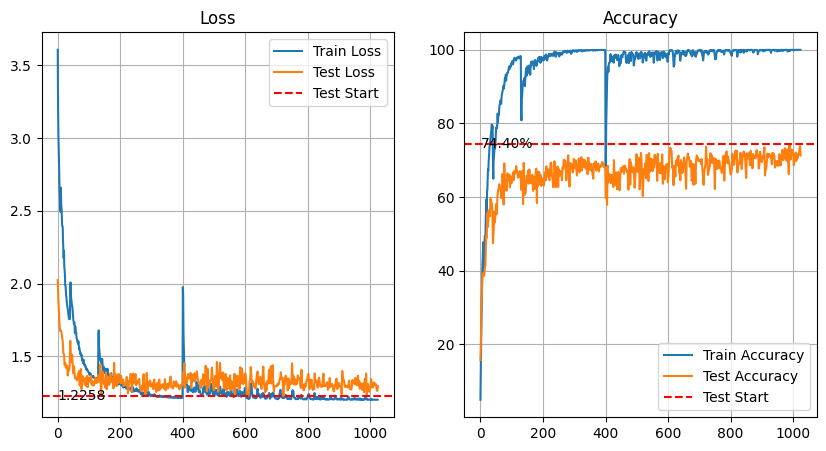

In [10]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc = [stat[1] for stat in train_stats]
test_loss = [stat[0] for stat in test_stats]
test_acc = [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [11]:
# !pip install seaborn

100%|██████████| 14/14 [00:00<00:00, 21.94it/s]


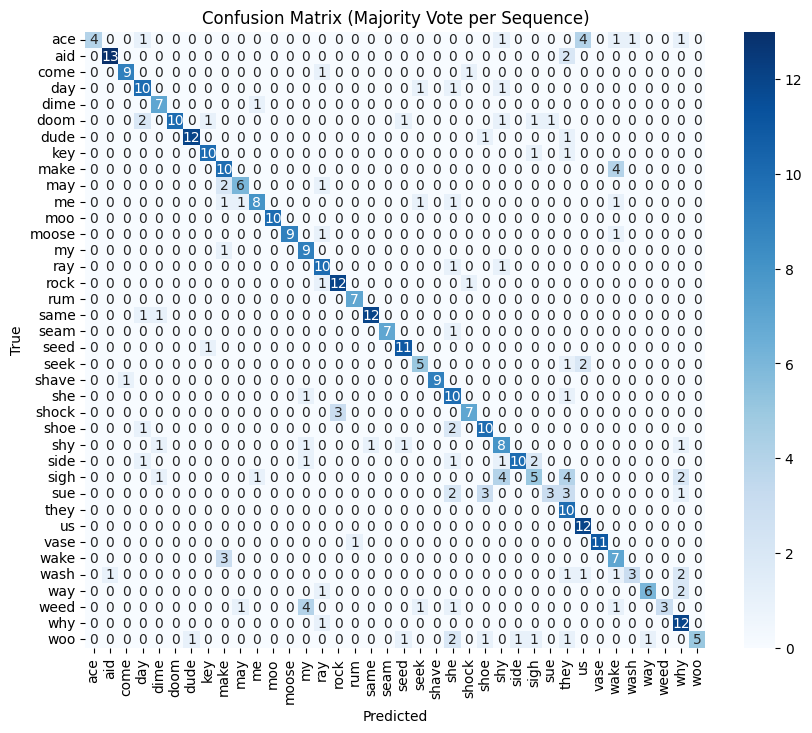

In [12]:
import torch
from tqdm import tqdm
from collections import Counter

def evaluate_model(model, dataloader, device='cpu'):
    """
    Evaluate model in a token-level scenario but produce one label per example
    by taking the majority vote of the token-level predictions. 
    """
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            # Move to device
            ids   = ids.to(device)   # [B, T] if you have a label per time step
            adc1  = adc1.to(device)
            adc2  = adc2.to(device)
            adc   = torch.stack((adc1, adc2), dim=1)
            mask  = model.compute_src_key_padding_mask(adc)  # [B, T]

            outputs = model(adc, mask)  # [B, C, T]
            ids = ids.unsqueeze(1).repeat(1, outputs.size(-1))
            # Argmax over the class dimension => [B, T]
            token_preds = outputs.argmax(dim=1)

            # For each sequence in the batch, get the majority predicted token
            batch_size = token_preds.size(0)
            for b in range(batch_size):
                # If ignoring padded tokens in your majority vote:
                valid_indices = (~mask[b]).nonzero().squeeze(-1)  # time steps that are not pad
                valid_preds_b = token_preds[b, valid_indices]      # predictions for valid tokens
                # If your true label is also time‐step wise (e.g. `ids[b]` is shape [T]):
                valid_ids_b = ids[b, valid_indices]   # the labels, ignoring padded tokens
                # If you have only one label per entire sequence, skip the majority step for labels.

                # 1) Find majority among predicted tokens
                if valid_preds_b.numel() == 0:
                    # Edge case: if everything is padded. 
                    # Decide on a placeholder or skip. Here we'll just skip.
                    continue
                pred_counter = Counter(valid_preds_b.cpu().numpy())
                pred_majority = pred_counter.most_common(1)[0][0]

                # 2) Find majority among *true* tokens (if you truly have multiple valid labels
                #    for each example). If you only have 1 label per sequence, then you can just
                #    do `true_label = ids[b].item()`. 
                label_counter = Counter(valid_ids_b.cpu().numpy())
                label_majority = label_counter.most_common(1)[0][0]

                all_preds.append(pred_majority)
                all_labels.append(label_majority)

    return all_labels, all_preds

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels, preds = evaluate_model(model, val_loader, device=global_device)
conf_matrix = confusion_matrix(labels, preds)

# Suppose you have an integer -> name mapping in `dataset.id_to_dataset()`
# If your valid classes are, say, [0..N-1], build label names:
label_names = [dataset.id_to_dataset(label_idx) for label_idx in range(38)]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Majority Vote per Sequence)')
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model and generate the confusion matrix
def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(adc)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ids.cpu().numpy())
    
    return all_labels, all_preds

# Evaluate the model on the validation set
labels, preds = evaluate_model(model, val_loader, device=global_device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Replace IDs with dataset names
label_names = [dataset.id_to_dataset(label) for label in range(output_length)]
pred_names = [dataset.id_to_dataset(pred) for pred in range(output_length)]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

100%|██████████| 14/14 [00:00<00:00, 31.52it/s]


ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets